### DQN Agent

In [11]:
import gym
import random
import numpy as np
import pandas as pd 
import math
from collections import namedtuple, deque

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import matplotlib
import matplotlib.pyplot as plt

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

# if GPU is to be used
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [23]:
class Q_Network(nn.Module):
    def __init__(self, N_STATES, N_ACTIONS,N_NODES_1,N_NODES_2,seed):
        super(Q_Network, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.layer1 = nn.Linear(N_STATES, N_NODES_1)  ## Input layer
        self.layer2 = nn.Linear(N_NODES_1, N_NODES_2) ## Hidden layer
        self.layer3 = nn.Linear(N_NODES_2, N_ACTIONS) ## Output layer
 
    def forward(self, state):
        x = F.relu(self.layer1(state))
        x = F.relu(self.layer2(x))
        return self.layer3(x)

In [24]:
class ReplayMemory:

    def __init__(self, N_ACTIONS, capacity, batch_size, seed):
        self.N_ACTIONS = N_ACTIONS
        self.memory = deque(maxlen=capacity)  
        self.batch_size = batch_size
        self.transition = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
    
    def push(self, state, action, reward, next_state, done):
        self.memory.append(self.transition(state, action, reward, next_state, done))
    
    def sample(self):
        transitions = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([i.state for i in transitions if i is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([i.action for i in transitions if i is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([i.reward for i in transitions if i is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([i.next_state for i in transitions if i is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([i.done for i in transitions if i is not None]).astype(np.uint8)).float().to(device)
  
        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        return len(self.memory)

In [25]:
class Agent():
    
    def __init__(self, N_STATES, N_ACTIONS, N_NODES_1, N_NODES_2,seed,Update_Frequency,TAU):
        self.N_STATES = N_STATES
        self.N_ACTIONS = N_ACTIONS
        self.N_NODES_1=N_NODES_1
        self.N_NODES_2=N_NODES_2
        self.Update_Frequency=Update_Frequency
        self.TAU=TAU
        
        self.local_qnetwork = Q_Network(N_STATES, N_ACTIONS, N_NODES_1, N_NODES_2, seed).to(device)
        self.target_qnetwork =Q_Network(N_STATES, N_ACTIONS, N_NODES_1, N_NODES_2, seed).to(device)
        
        self.optimizer = optim.Adam(self.local_qnetwork.parameters(), lr=LR)
        self.memory = ReplayMemory(N_ACTIONS,capacity, batch_size, seed)
        self.times = 0
        
    # select_action
    def act(self,state,eps=0.):
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
  
        with torch.no_grad():
            action_values = self.local_qnetwork(state)
        
        if random.random() > eps:
            return np.argmax(action_values.data.numpy())
        else:
            return random.choice(np.arange(self.N_ACTIONS))
        
    def learn(self, state, action, reward, next_state, done):
        self.memory.push(state, action, reward, next_state, done)
        self.times=self.times +1
        if self.times % self.Update_Frequency  == 0: ## Learn per fix step
            if len(self.memory) > batch_size:
                ## random select X observations, where X is the batch_size
                states, actions, rewards, next_states, dones = self.memory.sample()
                
                next_q_targets = self.target_qnetwork(next_states).detach().max(1)[0].unsqueeze(1)
                q_target = rewards + (GAMMA * next_q_targets * (1 - dones))  
                q_expected  = self.local_qnetwork(states).gather(1, actions)  
                loss = F.mse_loss(q_expected, q_target)  

                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()

                # Update Target Network using soft update
                for target_param, local_param in zip(self.target_qnetwork.parameters(), self.local_qnetwork.parameters()):
                    target_param.data.copy_(self.TAU * local_param.data + (1.0 - self.TAU) * target_param.data)

In [26]:
## Environment Seeting and HyperParameters
env = gym.make('LunarLander-v2')
env.seed(0)
N_ACTIONS = env.action_space.n  
N_STATES = env.observation_space.shape[0] 
N_NODES_1=64  ## Nodes of NN
N_NODES_2=64  ## Nodes of NN
seed=0 ## Random_seed of NN

capacity = 100000        ## replay memory size
batch_size = 64         ## batch size

GAMMA = 0.99
TAU = 0.005 # TAU is the update rate of the target network
LR = 0.001 # LR is the learning rate of the ``Adam`` optimizer

Update_Frequency=4

In [27]:
### Training The DQN 
number_episodes = 1000
max_episode = 1000
scores_on_100_episodes = deque(maxlen=100)
eps_start = 1.0
eps_end = 0.01
eps_decay_rate = 0.995
eps= eps_start
scores = [] 

agent = Agent(N_STATES, N_ACTIONS, N_NODES_1, N_NODES_2, seed,Update_Frequency,TAU)
 
for i_episode in range(1, number_episodes+1):
    state = env.reset()
    score = 0
    for t in range(max_episode):
        action = agent.act(state, eps)
        next_state, reward, done, _ = env.step(action)
        agent.learn(state, action, reward, next_state, done)
        state = next_state
        score += reward
        if done:
            break 
    scores_on_100_episodes.append(score)       # save most recent score
    scores.append(score)              # save most recent score
    eps = max(eps_end, eps_decay_rate*eps) # decrease epsilon
    print(i_episode, np.mean(scores_on_100_episodes))

torch.save(agent.local_qnetwork.state_dict(), 'checkpoint.pth')## save the last training       
        
fig = plt.figure()
ax = fig.add_subplot(111)
plt.scatter(np.arange(len(scores)), scores)
plt.title('Reward for each training episode ')
plt.ylabel('Reward')
plt.xlabel('Episode Numbers')
plt.show()
plt.savefig('Figure 1: Reward for each training episode')
plt.close()

1 -280.78584401925707
2 -253.75652210541588
3 -191.89848013390633
4 -175.43785646577334
5 -162.29421776612458
6 -150.11287267431013
7 -139.51957333951276
8 -140.86330452878047
9 -135.6686653649656
10 -161.63964480790486
11 -149.88686397171446
12 -155.68808877404473
13 -165.62107395744604
14 -170.2854336655044
15 -172.83401741610206
16 -182.30549931094174
17 -178.61213891136367
18 -183.41980291292668
19 -184.57443041418958


KeyboardInterrupt: 

1 244.26603957671446
2 217.54068736737082
3 256.85738381848915
4 279.9629324130277
5 259.4904064485996
6 282.0688391898219
7 286.69363258347573
8 254.68900980605596
9 266.33008282956916
10 297.4062921046714
11 252.7969003604669
12 250.87037294433452
13 251.40712880324278
14 273.0851364021745
15 234.1256312774468
16 197.06642080803925
17 288.16124255758865
18 249.0706795621561
19 270.9603228268375
20 300.45072227938454
21 264.8156928666077
22 235.673336432492
23 268.76995373682576
24 225.5462125206485
25 223.5425443858781
26 254.0242304483801
27 215.7878859251765
28 297.5156829285921
29 206.80827296853602
30 269.8068936438701
31 190.75253487575117
32 280.2762842149033
33 220.53288071943444
34 214.91419301900095
35 203.65201994284925
36 216.5906754230607
37 268.3719469028295
38 166.61304048422056
39 216.7286392565362
40 248.2299919319603
41 285.77995750721425
42 215.20020498883392
43 249.40773806739404
44 222.6477013029483
45 155.80312907709202
46 215.6376253878397
47 232.21413199076466


369 303.936525602327
370 254.26385957763117
371 241.975095190763
372 248.55035904212252
373 233.14268030525776
374 277.8316876190965
375 255.60904496767424
376 291.34779584701835
377 249.1036809165535
378 279.8290684581741
379 274.7123898922005
380 307.35856550479355
381 273.25933873061064
382 248.7915921140015
383 267.2304697340602
384 239.88885839176163
385 246.21099999981823
386 289.3431045672892
387 230.7138323292789
388 268.41839488622145
389 276.2839637047621
390 270.92750001257286
391 290.9411555929255
392 221.67769497126412
393 286.4623360288472
394 242.2628118932919
395 -173.3741155534135
396 222.63572299113184
397 235.6694499893024
398 257.54198342562347
399 264.11177918562726
400 272.73425585054486
401 258.3769599740318
402 241.39825896832383
403 270.31646707892435
404 260.6264598963697
405 253.60872279137584
406 254.11522175150682
407 281.72909207755913
408 235.84457352949613
409 278.5094241786784
410 223.526624265805
411 269.9373772645187
412 259.71649465970097
413 264.662

734 268.20801313847267
735 296.15691557956814
736 297.3225328035187
737 292.3142418814805
738 291.62374683137074
739 265.74012975088704
740 301.7177937246302
741 54.80666603263887
742 276.7722568542771
743 258.54659157865854
744 304.71647126453445
745 241.12292932857525
746 302.28410536161164
747 294.95732413126973
748 288.64988437434715
749 295.3116082274015
750 226.49234913298
751 276.7625447176215
752 284.4919349456175
753 302.32191154257475
754 239.50963065897093
755 280.76237925564
756 277.265842685703
757 258.35067761466354
758 284.79687087037826
759 308.4508893569673
760 288.8785859334572
761 63.08309811902106
762 289.0532533517205
763 249.22487748435782
764 268.2457567764555
765 247.4762286526847
766 242.26498379566632
767 71.67103553242694
768 300.13043490539724
769 290.2306268800504
770 292.2389643904934
771 267.64024985966864
772 241.68721983032083
773 247.36278959639046
774 216.73673998955235
775 275.7970185193522
776 265.9951886901566
777 301.5022370716486
778 274.64157245

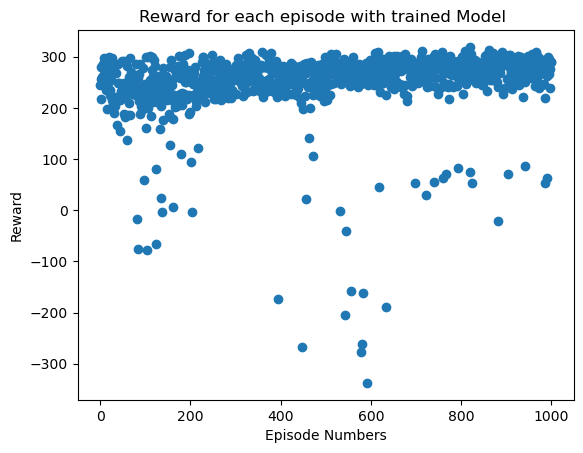

In [7]:
### Using Trained DQN

agent.local_qnetwork.load_state_dict(torch.load('checkpoint.pth'))

scores=[]
scores_on_100_episodes = deque(maxlen=100)
score_100=[]
for i_episode in range(1, 1001):
    state = env.reset()
    score = 0
    for t in range(1000):
        action = agent.act(state, eps)
        next_state, reward, done, _ = env.step(action)
        agent.step(state, action, reward, next_state, done)
        state = next_state
        score += reward
        if done:
            break         
    scores.append(score)  
    scores_on_100_episodes.append(score)
    score_100.append(np.mean(scores_on_100_episodes))  
    print(i_episode, score)

        
fig = plt.figure()
ax = fig.add_subplot(111)
plt.scatter(np.arange(len(scores)), scores)
plt.title('Reward for each episode with trained Model ')
plt.ylabel('Reward')
plt.xlabel('Episode Numbers')
plt.show()
plt.savefig('Figure 2: Reward for each episode with trained Model')
plt.close()

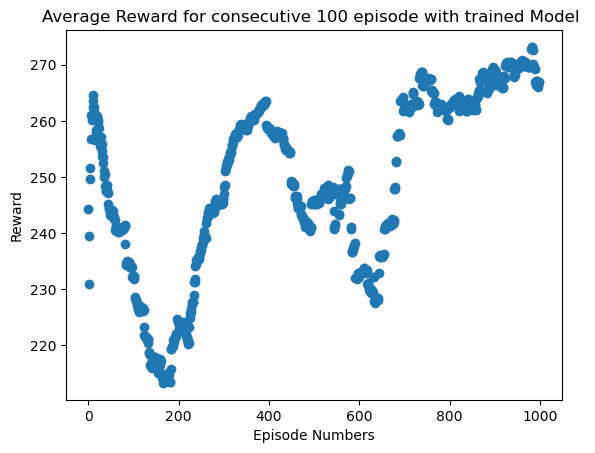

In [12]:
fig = plt.figure()
ax.set_xticks(np.arange(0,1000,100))
plt.scatter(np.arange(len(score_100)), score_100)
plt.title('Average Reward for consecutive 100 episode with trained Model ')
plt.ylabel('Reward')
plt.xlabel('Episode Numbers')
plt.show()
plt.savefig('Figure 2-1: Average Reward for consecutive 100 episode with trained Model')
plt.close()

### Tunning HyperParameters

In [35]:
### Tunning HyperParameters
def DQN(N_NODES_1,N_NODES_2,batch_size,GAMMA,TAU,LR,UF,eps_start,eps_end,eps_decay_rate):
    
    N_NODES_1=N_NODES_1      ## Nodes of NN
    N_NODES_2=N_NODES_2      ## Nodes of NN
    batch_size = batch_size  ## batch size
    GAMMA = GAMMA
    TAU =TAU ## 0.005 # TAU is the update rate of the target network
    LR = LR ## 1e-4 # LR is the learning rate of the ``AdamW`` optimizer
    Update_Frequency=UF
    
    scores_on_100_episodes = deque(maxlen=100)
    eps_start = eps_start
    eps_end = eps_end
    eps_decay_rate = eps_decay_rate
    eps= eps_start
    scores = [] 
    
    End_episode=[0] ## Store how quick this model reach 200 target

    agent = Agent(N_STATES, N_ACTIONS, N_NODES_1, N_NODES_2, seed,Update_Frequency,TAU)
 
    for i_episode in range(1, number_episodes+1):
        state = env.reset()
        score = 0
        for t in range(max_episode):
            action = agent.act(state, eps)
            next_state, reward, done, _ = env.step(action)
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break 
        scores_on_100_episodes.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        eps = max(eps_end, eps_decay_rate*eps) # decrease epsilon
        if np.mean(scores_on_100_episodes)>=200.0:
            End_episode.append(i_episode)
        if i_episode % 100==0:
            print("Episode Progress:","   ",i_episode)
    return scores,End_episode[1],(i_episode,N_NODES_1,N_NODES_2,batch_size,GAMMA,TAU,LR,UF,eps_start,eps_end,eps_decay_rate)

In [32]:
### Parameters Combination ( 4 loops require 22 min * 3 * 4 * 4 * 2= 35.2 h)
env = gym.make('LunarLander-v2')
env.seed(0)
number_episodes = 1000
max_episode = 1000
N_ACTIONS = env.action_space.n  
N_STATES = env.observation_space.shape[0] 
eps_start = 1.0
eps_end = 0.01
eps_decay_rate = 0.995
seed=0
capacity = 100000 

from tqdm import tqdm

HP_dict={}
i=1
for batch_size in tqdm([64,128,256]):
    for TAU in tqdm([0.0005,0.001,0.01,0.1]):   
        for LR in tqdm([0.0005,0.001,0.01,0.1]):
            for UF in tqdm([4,8]):
                HP_dict[i]=DQN(N_NODES_1,N_NODES_2,batch_size,GAMMA,TAU,LR,UF,eps_start,eps_end,eps_decay_rate)
                i+=1
np.save('HP.npy',HP_dict)

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]


  0%|          | 0/2 [00:00<?, ?it/s]

Episode Progress:     1
Episode Progress:     2
Episode Progress:     3
Episode Progress:     4
Episode Progress:     5
Episode Progress:     6
Episode Progress:     7
Episode Progress:     8
Episode Progress:     9
Episode Progress:     10
Episode Progress:     11
Episode Progress:     12
Episode Progress:     13
Episode Progress:     14
Episode Progress:     15
Episode Progress:     16
Episode Progress:     17
Episode Progress:     18
Episode Progress:     19
Episode Progress:     20
Episode Progress:     21
Episode Progress:     22
Episode Progress:     23
Episode Progress:     24
Episode Progress:     25
Episode Progress:     26
Episode Progress:     27
Episode Progress:     28
Episode Progress:     29
Episode Progress:     30
Episode Progress:     31
Episode Progress:     32
Episode Progress:     33
Episode Progress:     34
Episode Progress:     35
Episode Progress:     36
Episode Progress:     37
Episode Progress:     38
Episode Progress:     39
Episode Progress:     40
Episode P

Episode Progress:     321
Episode Progress:     322
Episode Progress:     323
Episode Progress:     324
Episode Progress:     325
Episode Progress:     326
Episode Progress:     327
Episode Progress:     328
Episode Progress:     329
Episode Progress:     330
Episode Progress:     331
Episode Progress:     332
Episode Progress:     333
Episode Progress:     334
Episode Progress:     335
Episode Progress:     336
Episode Progress:     337
Episode Progress:     338
Episode Progress:     339
Episode Progress:     340
Episode Progress:     341
Episode Progress:     342
Episode Progress:     343
Episode Progress:     344
Episode Progress:     345
Episode Progress:     346
Episode Progress:     347
Episode Progress:     348
Episode Progress:     349
Episode Progress:     350
Episode Progress:     351
Episode Progress:     352
Episode Progress:     353
Episode Progress:     354
Episode Progress:     355
Episode Progress:     356
Episode Progress:     357
Episode Progress:     358
Episode Prog

Episode Progress:     637
Episode Progress:     638
Episode Progress:     639
Episode Progress:     640
Episode Progress:     641
Episode Progress:     642
Episode Progress:     643
Episode Progress:     644
Episode Progress:     645
Episode Progress:     646
Episode Progress:     647
Episode Progress:     648
Episode Progress:     649
Episode Progress:     650
Episode Progress:     651
Episode Progress:     652
Episode Progress:     653
Episode Progress:     654
Episode Progress:     655
Episode Progress:     656
Episode Progress:     657
Episode Progress:     658
Episode Progress:     659
Episode Progress:     660
Episode Progress:     661
Episode Progress:     662
Episode Progress:     663
Episode Progress:     664
Episode Progress:     665
Episode Progress:     666
Episode Progress:     667
Episode Progress:     668
Episode Progress:     669
Episode Progress:     670
Episode Progress:     671
Episode Progress:     672
Episode Progress:     673
Episode Progress:     674
Episode Prog

Episode Progress:     953
Episode Progress:     954
Episode Progress:     955
Episode Progress:     956
Episode Progress:     957
Episode Progress:     958
Episode Progress:     959
Episode Progress:     960
Episode Progress:     961
Episode Progress:     962
Episode Progress:     963
Episode Progress:     964
Episode Progress:     965
Episode Progress:     966
Episode Progress:     967
Episode Progress:     968
Episode Progress:     969
Episode Progress:     970
Episode Progress:     971
Episode Progress:     972
Episode Progress:     973
Episode Progress:     974
Episode Progress:     975
Episode Progress:     976
Episode Progress:     977
Episode Progress:     978
Episode Progress:     979
Episode Progress:     980
Episode Progress:     981
Episode Progress:     982
Episode Progress:     983
Episode Progress:     984
Episode Progress:     985
Episode Progress:     986
Episode Progress:     987
Episode Progress:     988
Episode Progress:     989
Episode Progress:     990
Episode Prog




 50%|█████     | 1/2 [42:55<42:55, 2575.29s/it]

Episode Progress:     1000
Episode Progress:     1
Episode Progress:     2
Episode Progress:     3
Episode Progress:     4
Episode Progress:     5
Episode Progress:     6
Episode Progress:     7
Episode Progress:     8
Episode Progress:     9
Episode Progress:     10
Episode Progress:     11
Episode Progress:     12
Episode Progress:     13
Episode Progress:     14
Episode Progress:     15
Episode Progress:     16
Episode Progress:     17
Episode Progress:     18
Episode Progress:     19
Episode Progress:     20
Episode Progress:     21
Episode Progress:     22
Episode Progress:     23
Episode Progress:     24
Episode Progress:     25
Episode Progress:     26
Episode Progress:     27
Episode Progress:     28
Episode Progress:     29
Episode Progress:     30
Episode Progress:     31
Episode Progress:     32
Episode Progress:     33
Episode Progress:     34
Episode Progress:     35
Episode Progress:     36
Episode Progress:     37
Episode Progress:     38
Episode Progress:     39
Episode

Episode Progress:     320
Episode Progress:     321
Episode Progress:     322
Episode Progress:     323
Episode Progress:     324
Episode Progress:     325
Episode Progress:     326
Episode Progress:     327
Episode Progress:     328
Episode Progress:     329
Episode Progress:     330
Episode Progress:     331
Episode Progress:     332
Episode Progress:     333
Episode Progress:     334
Episode Progress:     335
Episode Progress:     336
Episode Progress:     337
Episode Progress:     338
Episode Progress:     339
Episode Progress:     340
Episode Progress:     341
Episode Progress:     342
Episode Progress:     343
Episode Progress:     344
Episode Progress:     345
Episode Progress:     346
Episode Progress:     347
Episode Progress:     348
Episode Progress:     349
Episode Progress:     350
Episode Progress:     351
Episode Progress:     352
Episode Progress:     353
Episode Progress:     354
Episode Progress:     355
Episode Progress:     356
Episode Progress:     357
Episode Prog

Episode Progress:     636
Episode Progress:     637
Episode Progress:     638
Episode Progress:     639
Episode Progress:     640
Episode Progress:     641
Episode Progress:     642
Episode Progress:     643
Episode Progress:     644
Episode Progress:     645
Episode Progress:     646
Episode Progress:     647
Episode Progress:     648
Episode Progress:     649
Episode Progress:     650
Episode Progress:     651
Episode Progress:     652
Episode Progress:     653
Episode Progress:     654
Episode Progress:     655
Episode Progress:     656
Episode Progress:     657
Episode Progress:     658
Episode Progress:     659
Episode Progress:     660
Episode Progress:     661
Episode Progress:     662
Episode Progress:     663
Episode Progress:     664
Episode Progress:     665
Episode Progress:     666
Episode Progress:     667
Episode Progress:     668
Episode Progress:     669
Episode Progress:     670
Episode Progress:     671
Episode Progress:     672
Episode Progress:     673
Episode Prog

Episode Progress:     952
Episode Progress:     953
Episode Progress:     954
Episode Progress:     955
Episode Progress:     956
Episode Progress:     957
Episode Progress:     958
Episode Progress:     959
Episode Progress:     960
Episode Progress:     961
Episode Progress:     962
Episode Progress:     963
Episode Progress:     964
Episode Progress:     965
Episode Progress:     966
Episode Progress:     967
Episode Progress:     968
Episode Progress:     969
Episode Progress:     970
Episode Progress:     971
Episode Progress:     972
Episode Progress:     973
Episode Progress:     974
Episode Progress:     975
Episode Progress:     976
Episode Progress:     977
Episode Progress:     978
Episode Progress:     979
Episode Progress:     980
Episode Progress:     981
Episode Progress:     982
Episode Progress:     983
Episode Progress:     984
Episode Progress:     985
Episode Progress:     986
Episode Progress:     987
Episode Progress:     988
Episode Progress:     989
Episode Prog




100%|██████████| 2/2 [1:13:31<00:00, 2205.54s/it]


 25%|██▌       | 1/4 [1:13:31<3:40:33, 4411.10s/it]

Episode Progress:     1000





  0%|          | 0/2 [00:00<?, ?it/s]

Episode Progress:     1
Episode Progress:     2
Episode Progress:     3
Episode Progress:     4
Episode Progress:     5
Episode Progress:     6
Episode Progress:     7
Episode Progress:     8
Episode Progress:     9
Episode Progress:     10
Episode Progress:     11
Episode Progress:     12
Episode Progress:     13
Episode Progress:     14
Episode Progress:     15
Episode Progress:     16
Episode Progress:     17
Episode Progress:     18
Episode Progress:     19
Episode Progress:     20
Episode Progress:     21
Episode Progress:     22
Episode Progress:     23
Episode Progress:     24
Episode Progress:     25
Episode Progress:     26
Episode Progress:     27
Episode Progress:     28
Episode Progress:     29
Episode Progress:     30
Episode Progress:     31
Episode Progress:     32
Episode Progress:     33
Episode Progress:     34
Episode Progress:     35
Episode Progress:     36
Episode Progress:     37
Episode Progress:     38
Episode Progress:     39
Episode Progress:     40
Episode P

Episode Progress:     321
Episode Progress:     322
Episode Progress:     323
Episode Progress:     324
Episode Progress:     325
Episode Progress:     326
Episode Progress:     327
Episode Progress:     328
Episode Progress:     329
Episode Progress:     330
Episode Progress:     331
Episode Progress:     332
Episode Progress:     333
Episode Progress:     334
Episode Progress:     335
Episode Progress:     336
Episode Progress:     337
Episode Progress:     338
Episode Progress:     339
Episode Progress:     340
Episode Progress:     341
Episode Progress:     342
Episode Progress:     343
Episode Progress:     344
Episode Progress:     345
Episode Progress:     346
Episode Progress:     347
Episode Progress:     348
Episode Progress:     349
Episode Progress:     350
Episode Progress:     351
Episode Progress:     352
Episode Progress:     353
Episode Progress:     354
Episode Progress:     355
Episode Progress:     356
Episode Progress:     357
Episode Progress:     358
Episode Prog

Episode Progress:     637
Episode Progress:     638
Episode Progress:     639
Episode Progress:     640
Episode Progress:     641
Episode Progress:     642
Episode Progress:     643
Episode Progress:     644
Episode Progress:     645
Episode Progress:     646
Episode Progress:     647
Episode Progress:     648
Episode Progress:     649
Episode Progress:     650
Episode Progress:     651
Episode Progress:     652
Episode Progress:     653
Episode Progress:     654
Episode Progress:     655
Episode Progress:     656
Episode Progress:     657
Episode Progress:     658
Episode Progress:     659
Episode Progress:     660
Episode Progress:     661
Episode Progress:     662
Episode Progress:     663
Episode Progress:     664
Episode Progress:     665
Episode Progress:     666
Episode Progress:     667
Episode Progress:     668
Episode Progress:     669
Episode Progress:     670
Episode Progress:     671
Episode Progress:     672
Episode Progress:     673
Episode Progress:     674
Episode Prog

Episode Progress:     953
Episode Progress:     954
Episode Progress:     955
Episode Progress:     956
Episode Progress:     957
Episode Progress:     958
Episode Progress:     959
Episode Progress:     960
Episode Progress:     961
Episode Progress:     962
Episode Progress:     963
Episode Progress:     964
Episode Progress:     965
Episode Progress:     966
Episode Progress:     967
Episode Progress:     968
Episode Progress:     969
Episode Progress:     970
Episode Progress:     971
Episode Progress:     972
Episode Progress:     973
Episode Progress:     974
Episode Progress:     975
Episode Progress:     976
Episode Progress:     977
Episode Progress:     978
Episode Progress:     979
Episode Progress:     980
Episode Progress:     981
Episode Progress:     982
Episode Progress:     983
Episode Progress:     984
Episode Progress:     985
Episode Progress:     986
Episode Progress:     987
Episode Progress:     988
Episode Progress:     989
Episode Progress:     990
Episode Prog




 50%|█████     | 1/2 [34:18<34:18, 2058.32s/it]

Episode Progress:     1000
Episode Progress:     1
Episode Progress:     2
Episode Progress:     3
Episode Progress:     4
Episode Progress:     5
Episode Progress:     6
Episode Progress:     7
Episode Progress:     8
Episode Progress:     9
Episode Progress:     10
Episode Progress:     11
Episode Progress:     12
Episode Progress:     13
Episode Progress:     14
Episode Progress:     15
Episode Progress:     16
Episode Progress:     17
Episode Progress:     18
Episode Progress:     19
Episode Progress:     20
Episode Progress:     21
Episode Progress:     22
Episode Progress:     23
Episode Progress:     24
Episode Progress:     25
Episode Progress:     26
Episode Progress:     27
Episode Progress:     28
Episode Progress:     29
Episode Progress:     30
Episode Progress:     31
Episode Progress:     32
Episode Progress:     33
Episode Progress:     34
Episode Progress:     35
Episode Progress:     36
Episode Progress:     37
Episode Progress:     38
Episode Progress:     39
Episode

Episode Progress:     320
Episode Progress:     321
Episode Progress:     322
Episode Progress:     323
Episode Progress:     324
Episode Progress:     325
Episode Progress:     326
Episode Progress:     327
Episode Progress:     328
Episode Progress:     329
Episode Progress:     330
Episode Progress:     331
Episode Progress:     332
Episode Progress:     333
Episode Progress:     334
Episode Progress:     335
Episode Progress:     336
Episode Progress:     337
Episode Progress:     338
Episode Progress:     339
Episode Progress:     340
Episode Progress:     341
Episode Progress:     342
Episode Progress:     343
Episode Progress:     344
Episode Progress:     345
Episode Progress:     346
Episode Progress:     347
Episode Progress:     348
Episode Progress:     349
Episode Progress:     350
Episode Progress:     351
Episode Progress:     352
Episode Progress:     353
Episode Progress:     354
Episode Progress:     355
Episode Progress:     356
Episode Progress:     357
Episode Prog

Episode Progress:     636
Episode Progress:     637
Episode Progress:     638
Episode Progress:     639
Episode Progress:     640
Episode Progress:     641
Episode Progress:     642
Episode Progress:     643
Episode Progress:     644
Episode Progress:     645
Episode Progress:     646
Episode Progress:     647
Episode Progress:     648
Episode Progress:     649
Episode Progress:     650
Episode Progress:     651
Episode Progress:     652
Episode Progress:     653
Episode Progress:     654
Episode Progress:     655
Episode Progress:     656
Episode Progress:     657
Episode Progress:     658
Episode Progress:     659
Episode Progress:     660
Episode Progress:     661
Episode Progress:     662
Episode Progress:     663
Episode Progress:     664
Episode Progress:     665
Episode Progress:     666
Episode Progress:     667
Episode Progress:     668
Episode Progress:     669
Episode Progress:     670
Episode Progress:     671
Episode Progress:     672
Episode Progress:     673
Episode Prog

Episode Progress:     952
Episode Progress:     953
Episode Progress:     954
Episode Progress:     955
Episode Progress:     956
Episode Progress:     957
Episode Progress:     958
Episode Progress:     959
Episode Progress:     960
Episode Progress:     961
Episode Progress:     962
Episode Progress:     963
Episode Progress:     964
Episode Progress:     965
Episode Progress:     966
Episode Progress:     967
Episode Progress:     968
Episode Progress:     969
Episode Progress:     970
Episode Progress:     971
Episode Progress:     972
Episode Progress:     973
Episode Progress:     974
Episode Progress:     975
Episode Progress:     976
Episode Progress:     977
Episode Progress:     978
Episode Progress:     979
Episode Progress:     980
Episode Progress:     981
Episode Progress:     982
Episode Progress:     983
Episode Progress:     984
Episode Progress:     985
Episode Progress:     986
Episode Progress:     987
Episode Progress:     988
Episode Progress:     989
Episode Prog




100%|██████████| 2/2 [1:08:55<00:00, 2067.88s/it]


 50%|█████     | 2/4 [2:22:26<2:21:38, 4249.14s/it]

Episode Progress:     1000





  0%|          | 0/2 [00:00<?, ?it/s]

Episode Progress:     1
Episode Progress:     2
Episode Progress:     3
Episode Progress:     4
Episode Progress:     5
Episode Progress:     6
Episode Progress:     7
Episode Progress:     8
Episode Progress:     9
Episode Progress:     10
Episode Progress:     11
Episode Progress:     12
Episode Progress:     13
Episode Progress:     14
Episode Progress:     15
Episode Progress:     16
Episode Progress:     17
Episode Progress:     18
Episode Progress:     19
Episode Progress:     20
Episode Progress:     21
Episode Progress:     22
Episode Progress:     23
Episode Progress:     24
Episode Progress:     25
Episode Progress:     26
Episode Progress:     27
Episode Progress:     28
Episode Progress:     29
Episode Progress:     30
Episode Progress:     31
Episode Progress:     32
Episode Progress:     33
Episode Progress:     34
Episode Progress:     35
Episode Progress:     36
Episode Progress:     37
Episode Progress:     38
Episode Progress:     39
Episode Progress:     40
Episode P

Episode Progress:     321
Episode Progress:     322
Episode Progress:     323
Episode Progress:     324
Episode Progress:     325
Episode Progress:     326
Episode Progress:     327
Episode Progress:     328
Episode Progress:     329
Episode Progress:     330
Episode Progress:     331
Episode Progress:     332
Episode Progress:     333
Episode Progress:     334
Episode Progress:     335
Episode Progress:     336
Episode Progress:     337
Episode Progress:     338
Episode Progress:     339
Episode Progress:     340
Episode Progress:     341
Episode Progress:     342
Episode Progress:     343
Episode Progress:     344
Episode Progress:     345
Episode Progress:     346
Episode Progress:     347
Episode Progress:     348
Episode Progress:     349
Episode Progress:     350
Episode Progress:     351
Episode Progress:     352
Episode Progress:     353
Episode Progress:     354
Episode Progress:     355
Episode Progress:     356
Episode Progress:     357
Episode Progress:     358
Episode Prog

Episode Progress:     637
Episode Progress:     638
Episode Progress:     639
Episode Progress:     640
Episode Progress:     641
Episode Progress:     642
Episode Progress:     643
Episode Progress:     644
Episode Progress:     645
Episode Progress:     646
Episode Progress:     647
Episode Progress:     648
Episode Progress:     649
Episode Progress:     650
Episode Progress:     651
Episode Progress:     652
Episode Progress:     653
Episode Progress:     654
Episode Progress:     655
Episode Progress:     656
Episode Progress:     657
Episode Progress:     658
Episode Progress:     659
Episode Progress:     660
Episode Progress:     661
Episode Progress:     662
Episode Progress:     663
Episode Progress:     664
Episode Progress:     665
Episode Progress:     666
Episode Progress:     667
Episode Progress:     668
Episode Progress:     669
Episode Progress:     670
Episode Progress:     671
Episode Progress:     672
Episode Progress:     673
Episode Progress:     674
Episode Prog

Episode Progress:     953
Episode Progress:     954
Episode Progress:     955
Episode Progress:     956
Episode Progress:     957
Episode Progress:     958
Episode Progress:     959
Episode Progress:     960
Episode Progress:     961
Episode Progress:     962
Episode Progress:     963
Episode Progress:     964
Episode Progress:     965
Episode Progress:     966
Episode Progress:     967
Episode Progress:     968
Episode Progress:     969
Episode Progress:     970
Episode Progress:     971
Episode Progress:     972
Episode Progress:     973
Episode Progress:     974
Episode Progress:     975
Episode Progress:     976
Episode Progress:     977
Episode Progress:     978
Episode Progress:     979
Episode Progress:     980
Episode Progress:     981
Episode Progress:     982
Episode Progress:     983
Episode Progress:     984
Episode Progress:     985
Episode Progress:     986
Episode Progress:     987
Episode Progress:     988
Episode Progress:     989
Episode Progress:     990
Episode Prog




 50%|█████     | 1/2 [26:54<26:54, 1614.76s/it]

Episode Progress:     1000
Episode Progress:     1
Episode Progress:     2
Episode Progress:     3
Episode Progress:     4
Episode Progress:     5
Episode Progress:     6
Episode Progress:     7
Episode Progress:     8
Episode Progress:     9
Episode Progress:     10
Episode Progress:     11
Episode Progress:     12
Episode Progress:     13
Episode Progress:     14
Episode Progress:     15
Episode Progress:     16
Episode Progress:     17
Episode Progress:     18
Episode Progress:     19
Episode Progress:     20
Episode Progress:     21
Episode Progress:     22
Episode Progress:     23
Episode Progress:     24
Episode Progress:     25
Episode Progress:     26
Episode Progress:     27
Episode Progress:     28
Episode Progress:     29
Episode Progress:     30
Episode Progress:     31
Episode Progress:     32
Episode Progress:     33
Episode Progress:     34
Episode Progress:     35
Episode Progress:     36
Episode Progress:     37
Episode Progress:     38
Episode Progress:     39
Episode

Episode Progress:     320
Episode Progress:     321
Episode Progress:     322
Episode Progress:     323
Episode Progress:     324
Episode Progress:     325
Episode Progress:     326
Episode Progress:     327
Episode Progress:     328
Episode Progress:     329
Episode Progress:     330
Episode Progress:     331
Episode Progress:     332
Episode Progress:     333
Episode Progress:     334
Episode Progress:     335
Episode Progress:     336
Episode Progress:     337
Episode Progress:     338
Episode Progress:     339
Episode Progress:     340
Episode Progress:     341
Episode Progress:     342
Episode Progress:     343
Episode Progress:     344
Episode Progress:     345
Episode Progress:     346
Episode Progress:     347
Episode Progress:     348
Episode Progress:     349
Episode Progress:     350
Episode Progress:     351
Episode Progress:     352
Episode Progress:     353
Episode Progress:     354
Episode Progress:     355
Episode Progress:     356
Episode Progress:     357
Episode Prog

Episode Progress:     636
Episode Progress:     637
Episode Progress:     638
Episode Progress:     639
Episode Progress:     640
Episode Progress:     641
Episode Progress:     642
Episode Progress:     643
Episode Progress:     644
Episode Progress:     645
Episode Progress:     646
Episode Progress:     647
Episode Progress:     648
Episode Progress:     649
Episode Progress:     650
Episode Progress:     651
Episode Progress:     652
Episode Progress:     653
Episode Progress:     654
Episode Progress:     655
Episode Progress:     656
Episode Progress:     657
Episode Progress:     658
Episode Progress:     659
Episode Progress:     660
Episode Progress:     661
Episode Progress:     662
Episode Progress:     663
Episode Progress:     664
Episode Progress:     665
Episode Progress:     666
Episode Progress:     667
Episode Progress:     668
Episode Progress:     669
Episode Progress:     670
Episode Progress:     671
Episode Progress:     672
Episode Progress:     673
Episode Prog

Episode Progress:     952
Episode Progress:     953
Episode Progress:     954
Episode Progress:     955
Episode Progress:     956
Episode Progress:     957
Episode Progress:     958
Episode Progress:     959
Episode Progress:     960
Episode Progress:     961
Episode Progress:     962
Episode Progress:     963
Episode Progress:     964
Episode Progress:     965
Episode Progress:     966
Episode Progress:     967
Episode Progress:     968
Episode Progress:     969
Episode Progress:     970
Episode Progress:     971
Episode Progress:     972
Episode Progress:     973
Episode Progress:     974
Episode Progress:     975
Episode Progress:     976
Episode Progress:     977
Episode Progress:     978
Episode Progress:     979
Episode Progress:     980
Episode Progress:     981
Episode Progress:     982
Episode Progress:     983
Episode Progress:     984
Episode Progress:     985
Episode Progress:     986
Episode Progress:     987
Episode Progress:     988
Episode Progress:     989
Episode Prog




100%|██████████| 2/2 [1:01:51<00:00, 1855.59s/it]


 75%|███████▌  | 3/4 [3:24:18<1:06:43, 4003.50s/it]

Episode Progress:     1000





  0%|          | 0/2 [00:00<?, ?it/s]

Episode Progress:     1
Episode Progress:     2
Episode Progress:     3
Episode Progress:     4
Episode Progress:     5
Episode Progress:     6
Episode Progress:     7
Episode Progress:     8
Episode Progress:     9
Episode Progress:     10
Episode Progress:     11
Episode Progress:     12
Episode Progress:     13
Episode Progress:     14
Episode Progress:     15
Episode Progress:     16
Episode Progress:     17
Episode Progress:     18
Episode Progress:     19
Episode Progress:     20
Episode Progress:     21
Episode Progress:     22
Episode Progress:     23
Episode Progress:     24
Episode Progress:     25
Episode Progress:     26
Episode Progress:     27
Episode Progress:     28
Episode Progress:     29
Episode Progress:     30
Episode Progress:     31
Episode Progress:     32
Episode Progress:     33
Episode Progress:     34
Episode Progress:     35
Episode Progress:     36
Episode Progress:     37
Episode Progress:     38
Episode Progress:     39
Episode Progress:     40
Episode P

Episode Progress:     321
Episode Progress:     322
Episode Progress:     323
Episode Progress:     324
Episode Progress:     325
Episode Progress:     326
Episode Progress:     327
Episode Progress:     328
Episode Progress:     329
Episode Progress:     330
Episode Progress:     331
Episode Progress:     332
Episode Progress:     333
Episode Progress:     334
Episode Progress:     335
Episode Progress:     336
Episode Progress:     337
Episode Progress:     338
Episode Progress:     339
Episode Progress:     340
Episode Progress:     341
Episode Progress:     342
Episode Progress:     343
Episode Progress:     344
Episode Progress:     345
Episode Progress:     346
Episode Progress:     347
Episode Progress:     348
Episode Progress:     349
Episode Progress:     350
Episode Progress:     351
Episode Progress:     352
Episode Progress:     353
Episode Progress:     354
Episode Progress:     355
Episode Progress:     356
Episode Progress:     357
Episode Progress:     358
Episode Prog

Episode Progress:     637
Episode Progress:     638
Episode Progress:     639
Episode Progress:     640
Episode Progress:     641
Episode Progress:     642
Episode Progress:     643
Episode Progress:     644
Episode Progress:     645
Episode Progress:     646
Episode Progress:     647
Episode Progress:     648
Episode Progress:     649
Episode Progress:     650
Episode Progress:     651
Episode Progress:     652
Episode Progress:     653
Episode Progress:     654
Episode Progress:     655
Episode Progress:     656
Episode Progress:     657
Episode Progress:     658
Episode Progress:     659
Episode Progress:     660
Episode Progress:     661
Episode Progress:     662
Episode Progress:     663
Episode Progress:     664
Episode Progress:     665
Episode Progress:     666
Episode Progress:     667
Episode Progress:     668
Episode Progress:     669
Episode Progress:     670
Episode Progress:     671
Episode Progress:     672
Episode Progress:     673
Episode Progress:     674
Episode Prog

Episode Progress:     953
Episode Progress:     954
Episode Progress:     955
Episode Progress:     956
Episode Progress:     957
Episode Progress:     958
Episode Progress:     959
Episode Progress:     960
Episode Progress:     961
Episode Progress:     962
Episode Progress:     963
Episode Progress:     964
Episode Progress:     965
Episode Progress:     966
Episode Progress:     967
Episode Progress:     968
Episode Progress:     969
Episode Progress:     970
Episode Progress:     971
Episode Progress:     972
Episode Progress:     973
Episode Progress:     974
Episode Progress:     975
Episode Progress:     976
Episode Progress:     977
Episode Progress:     978
Episode Progress:     979
Episode Progress:     980
Episode Progress:     981
Episode Progress:     982
Episode Progress:     983
Episode Progress:     984
Episode Progress:     985
Episode Progress:     986
Episode Progress:     987
Episode Progress:     988
Episode Progress:     989
Episode Progress:     990
Episode Prog

Episode Progress:     998
Episode Progress:     999
Episode Progress:     1000


 50%|█████     | 1/2 [01:54<01:54, 114.04s/it]

Episode Progress:     1
Episode Progress:     2
Episode Progress:     3
Episode Progress:     4
Episode Progress:     5
Episode Progress:     6
Episode Progress:     7
Episode Progress:     8
Episode Progress:     9
Episode Progress:     10
Episode Progress:     11
Episode Progress:     12
Episode Progress:     13
Episode Progress:     14
Episode Progress:     15
Episode Progress:     16
Episode Progress:     17
Episode Progress:     18
Episode Progress:     19
Episode Progress:     20
Episode Progress:     21
Episode Progress:     22
Episode Progress:     23
Episode Progress:     24
Episode Progress:     25
Episode Progress:     26
Episode Progress:     27
Episode Progress:     28
Episode Progress:     29
Episode Progress:     30
Episode Progress:     31
Episode Progress:     32
Episode Progress:     33
Episode Progress:     34
Episode Progress:     35
Episode Progress:     36
Episode Progress:     37
Episode Progress:     38
Episode Progress:     39
Episode Progress:     40
Episode P

Episode Progress:     323
Episode Progress:     324
Episode Progress:     325
Episode Progress:     326
Episode Progress:     327
Episode Progress:     328
Episode Progress:     329
Episode Progress:     330
Episode Progress:     331
Episode Progress:     332
Episode Progress:     333
Episode Progress:     334
Episode Progress:     335
Episode Progress:     336
Episode Progress:     337
Episode Progress:     338
Episode Progress:     339
Episode Progress:     340
Episode Progress:     341
Episode Progress:     342
Episode Progress:     343
Episode Progress:     344
Episode Progress:     345
Episode Progress:     346
Episode Progress:     347
Episode Progress:     348
Episode Progress:     349
Episode Progress:     350
Episode Progress:     351
Episode Progress:     352
Episode Progress:     353
Episode Progress:     354
Episode Progress:     355
Episode Progress:     356
Episode Progress:     357
Episode Progress:     358
Episode Progress:     359
Episode Progress:     360
Episode Prog

Episode Progress:     639
Episode Progress:     640
Episode Progress:     641
Episode Progress:     642
Episode Progress:     643
Episode Progress:     644
Episode Progress:     645
Episode Progress:     646
Episode Progress:     647
Episode Progress:     648
Episode Progress:     649
Episode Progress:     650
Episode Progress:     651
Episode Progress:     652
Episode Progress:     653
Episode Progress:     654
Episode Progress:     655
Episode Progress:     656
Episode Progress:     657
Episode Progress:     658
Episode Progress:     659
Episode Progress:     660
Episode Progress:     661
Episode Progress:     662
Episode Progress:     663
Episode Progress:     664
Episode Progress:     665
Episode Progress:     666
Episode Progress:     667
Episode Progress:     668
Episode Progress:     669
Episode Progress:     670
Episode Progress:     671
Episode Progress:     672
Episode Progress:     673
Episode Progress:     674
Episode Progress:     675
Episode Progress:     676
Episode Prog

Episode Progress:     955
Episode Progress:     956
Episode Progress:     957
Episode Progress:     958
Episode Progress:     959
Episode Progress:     960
Episode Progress:     961
Episode Progress:     962
Episode Progress:     963
Episode Progress:     964
Episode Progress:     965
Episode Progress:     966
Episode Progress:     967
Episode Progress:     968
Episode Progress:     969
Episode Progress:     970
Episode Progress:     971
Episode Progress:     972
Episode Progress:     973
Episode Progress:     974
Episode Progress:     975
Episode Progress:     976
Episode Progress:     977
Episode Progress:     978
Episode Progress:     979
Episode Progress:     980
Episode Progress:     981
Episode Progress:     982
Episode Progress:     983
Episode Progress:     984
Episode Progress:     985
Episode Progress:     986
Episode Progress:     987
Episode Progress:     988
Episode Progress:     989
Episode Progress:     990
Episode Progress:     991
Episode Progress:     992
Episode Prog




100%|██████████| 2/2 [04:21<00:00, 133.91s/it]

Episode Progress:     999
Episode Progress:     1000


100%|██████████| 2/2 [04:21<00:00, 130.94s/it]


100%|██████████| 4/4 [3:28:39<00:00, 3129.99s/it]  

 25%|██▌       | 1/4 [3:28:39<10:25:59, 12519.95s/it]

  0%|          | 0/4 [00:00<?, ?it/s]


  0%|          | 0/2 [00:00<?, ?it/s]

Episode Progress:     1
Episode Progress:     2
Episode Progress:     3
Episode Progress:     4
Episode Progress:     5
Episode Progress:     6
Episode Progress:     7
Episode Progress:     8
Episode Progress:     9
Episode Progress:     10
Episode Progress:     11
Episode Progress:     12
Episode Progress:     13
Episode Progress:     14
Episode Progress:     15
Episode Progress:     16
Episode Progress:     17
Episode Progress:     18
Episode Progress:     19
Episode Progress:     20
Episode Progress:     21
Episode Progress:     22
Episode Progress:     23
Episode Progress:     24
Episode Progress:     25
Episode Progress:     26
Episode Progress:     27
Episode Progress:     28
Episode Progress:     29
Episode Progress:     30
Episode Progress:     31
Episode Progress:     32
Episode Progress:     33
Episode Progress:     34
Episode Progress:     35
Episode Progress:     36
Episode Progress:     37
Episode Progress:     38
Episode Progress:     39
Episode Progress:     40
Episode P

Episode Progress:     321
Episode Progress:     322
Episode Progress:     323
Episode Progress:     324
Episode Progress:     325
Episode Progress:     326
Episode Progress:     327
Episode Progress:     328
Episode Progress:     329
Episode Progress:     330
Episode Progress:     331
Episode Progress:     332
Episode Progress:     333
Episode Progress:     334
Episode Progress:     335
Episode Progress:     336
Episode Progress:     337
Episode Progress:     338
Episode Progress:     339
Episode Progress:     340
Episode Progress:     341
Episode Progress:     342
Episode Progress:     343
Episode Progress:     344
Episode Progress:     345
Episode Progress:     346
Episode Progress:     347
Episode Progress:     348
Episode Progress:     349
Episode Progress:     350
Episode Progress:     351
Episode Progress:     352
Episode Progress:     353
Episode Progress:     354
Episode Progress:     355
Episode Progress:     356
Episode Progress:     357
Episode Progress:     358
Episode Prog

Episode Progress:     637
Episode Progress:     638
Episode Progress:     639
Episode Progress:     640
Episode Progress:     641
Episode Progress:     642
Episode Progress:     643
Episode Progress:     644
Episode Progress:     645
Episode Progress:     646
Episode Progress:     647
Episode Progress:     648
Episode Progress:     649
Episode Progress:     650
Episode Progress:     651
Episode Progress:     652
Episode Progress:     653
Episode Progress:     654
Episode Progress:     655
Episode Progress:     656
Episode Progress:     657
Episode Progress:     658
Episode Progress:     659
Episode Progress:     660
Episode Progress:     661
Episode Progress:     662
Episode Progress:     663
Episode Progress:     664
Episode Progress:     665
Episode Progress:     666
Episode Progress:     667
Episode Progress:     668
Episode Progress:     669
Episode Progress:     670
Episode Progress:     671
Episode Progress:     672
Episode Progress:     673
Episode Progress:     674
Episode Prog

Episode Progress:     953
Episode Progress:     954
Episode Progress:     955
Episode Progress:     956
Episode Progress:     957
Episode Progress:     958
Episode Progress:     959
Episode Progress:     960
Episode Progress:     961
Episode Progress:     962
Episode Progress:     963
Episode Progress:     964
Episode Progress:     965
Episode Progress:     966
Episode Progress:     967
Episode Progress:     968
Episode Progress:     969
Episode Progress:     970
Episode Progress:     971
Episode Progress:     972
Episode Progress:     973
Episode Progress:     974
Episode Progress:     975
Episode Progress:     976
Episode Progress:     977
Episode Progress:     978
Episode Progress:     979
Episode Progress:     980
Episode Progress:     981
Episode Progress:     982
Episode Progress:     983
Episode Progress:     984
Episode Progress:     985
Episode Progress:     986
Episode Progress:     987
Episode Progress:     988
Episode Progress:     989
Episode Progress:     990
Episode Prog




 50%|█████     | 1/2 [30:40<30:40, 1840.46s/it]

Episode Progress:     1000
Episode Progress:     1
Episode Progress:     2
Episode Progress:     3
Episode Progress:     4
Episode Progress:     5
Episode Progress:     6
Episode Progress:     7
Episode Progress:     8
Episode Progress:     9
Episode Progress:     10
Episode Progress:     11
Episode Progress:     12
Episode Progress:     13
Episode Progress:     14
Episode Progress:     15
Episode Progress:     16
Episode Progress:     17
Episode Progress:     18
Episode Progress:     19
Episode Progress:     20
Episode Progress:     21
Episode Progress:     22
Episode Progress:     23
Episode Progress:     24
Episode Progress:     25
Episode Progress:     26
Episode Progress:     27
Episode Progress:     28
Episode Progress:     29
Episode Progress:     30
Episode Progress:     31
Episode Progress:     32
Episode Progress:     33
Episode Progress:     34
Episode Progress:     35
Episode Progress:     36
Episode Progress:     37
Episode Progress:     38
Episode Progress:     39
Episode

Episode Progress:     320
Episode Progress:     321
Episode Progress:     322
Episode Progress:     323
Episode Progress:     324
Episode Progress:     325
Episode Progress:     326
Episode Progress:     327
Episode Progress:     328
Episode Progress:     329
Episode Progress:     330
Episode Progress:     331
Episode Progress:     332
Episode Progress:     333
Episode Progress:     334
Episode Progress:     335
Episode Progress:     336
Episode Progress:     337
Episode Progress:     338
Episode Progress:     339
Episode Progress:     340
Episode Progress:     341
Episode Progress:     342
Episode Progress:     343
Episode Progress:     344
Episode Progress:     345
Episode Progress:     346
Episode Progress:     347
Episode Progress:     348
Episode Progress:     349
Episode Progress:     350
Episode Progress:     351
Episode Progress:     352
Episode Progress:     353
Episode Progress:     354
Episode Progress:     355
Episode Progress:     356
Episode Progress:     357
Episode Prog

Episode Progress:     636
Episode Progress:     637
Episode Progress:     638
Episode Progress:     639
Episode Progress:     640
Episode Progress:     641
Episode Progress:     642
Episode Progress:     643
Episode Progress:     644
Episode Progress:     645
Episode Progress:     646
Episode Progress:     647
Episode Progress:     648
Episode Progress:     649
Episode Progress:     650
Episode Progress:     651
Episode Progress:     652
Episode Progress:     653
Episode Progress:     654
Episode Progress:     655
Episode Progress:     656
Episode Progress:     657
Episode Progress:     658
Episode Progress:     659
Episode Progress:     660
Episode Progress:     661
Episode Progress:     662
Episode Progress:     663
Episode Progress:     664
Episode Progress:     665
Episode Progress:     666
Episode Progress:     667
Episode Progress:     668
Episode Progress:     669
Episode Progress:     670
Episode Progress:     671
Episode Progress:     672
Episode Progress:     673
Episode Prog

Episode Progress:     952
Episode Progress:     953
Episode Progress:     954
Episode Progress:     955
Episode Progress:     956
Episode Progress:     957
Episode Progress:     958
Episode Progress:     959
Episode Progress:     960
Episode Progress:     961
Episode Progress:     962
Episode Progress:     963
Episode Progress:     964
Episode Progress:     965
Episode Progress:     966
Episode Progress:     967
Episode Progress:     968
Episode Progress:     969
Episode Progress:     970
Episode Progress:     971
Episode Progress:     972
Episode Progress:     973
Episode Progress:     974
Episode Progress:     975
Episode Progress:     976
Episode Progress:     977
Episode Progress:     978
Episode Progress:     979
Episode Progress:     980
Episode Progress:     981
Episode Progress:     982
Episode Progress:     983
Episode Progress:     984
Episode Progress:     985
Episode Progress:     986
Episode Progress:     987
Episode Progress:     988
Episode Progress:     989
Episode Prog




100%|██████████| 2/2 [54:42<00:00, 1641.42s/it]


 25%|██▌       | 1/4 [54:42<2:44:08, 3282.85s/it]

Episode Progress:     1000





  0%|          | 0/2 [00:00<?, ?it/s]

Episode Progress:     1
Episode Progress:     2
Episode Progress:     3
Episode Progress:     4
Episode Progress:     5
Episode Progress:     6
Episode Progress:     7
Episode Progress:     8
Episode Progress:     9
Episode Progress:     10
Episode Progress:     11
Episode Progress:     12
Episode Progress:     13
Episode Progress:     14
Episode Progress:     15
Episode Progress:     16
Episode Progress:     17
Episode Progress:     18
Episode Progress:     19
Episode Progress:     20
Episode Progress:     21
Episode Progress:     22
Episode Progress:     23
Episode Progress:     24
Episode Progress:     25
Episode Progress:     26
Episode Progress:     27
Episode Progress:     28
Episode Progress:     29
Episode Progress:     30
Episode Progress:     31
Episode Progress:     32
Episode Progress:     33
Episode Progress:     34
Episode Progress:     35
Episode Progress:     36
Episode Progress:     37
Episode Progress:     38
Episode Progress:     39
Episode Progress:     40
Episode P

Episode Progress:     321
Episode Progress:     322
Episode Progress:     323
Episode Progress:     324
Episode Progress:     325
Episode Progress:     326
Episode Progress:     327
Episode Progress:     328
Episode Progress:     329
Episode Progress:     330
Episode Progress:     331
Episode Progress:     332
Episode Progress:     333
Episode Progress:     334
Episode Progress:     335
Episode Progress:     336
Episode Progress:     337
Episode Progress:     338
Episode Progress:     339
Episode Progress:     340
Episode Progress:     341
Episode Progress:     342
Episode Progress:     343
Episode Progress:     344
Episode Progress:     345
Episode Progress:     346
Episode Progress:     347
Episode Progress:     348
Episode Progress:     349
Episode Progress:     350
Episode Progress:     351
Episode Progress:     352
Episode Progress:     353
Episode Progress:     354
Episode Progress:     355
Episode Progress:     356
Episode Progress:     357
Episode Progress:     358
Episode Prog

Episode Progress:     637
Episode Progress:     638
Episode Progress:     639
Episode Progress:     640
Episode Progress:     641
Episode Progress:     642
Episode Progress:     643
Episode Progress:     644
Episode Progress:     645
Episode Progress:     646
Episode Progress:     647
Episode Progress:     648
Episode Progress:     649
Episode Progress:     650
Episode Progress:     651
Episode Progress:     652
Episode Progress:     653
Episode Progress:     654
Episode Progress:     655
Episode Progress:     656
Episode Progress:     657
Episode Progress:     658
Episode Progress:     659
Episode Progress:     660
Episode Progress:     661
Episode Progress:     662
Episode Progress:     663
Episode Progress:     664
Episode Progress:     665
Episode Progress:     666
Episode Progress:     667
Episode Progress:     668
Episode Progress:     669
Episode Progress:     670
Episode Progress:     671
Episode Progress:     672
Episode Progress:     673
Episode Progress:     674
Episode Prog

Episode Progress:     953
Episode Progress:     954
Episode Progress:     955
Episode Progress:     956
Episode Progress:     957
Episode Progress:     958
Episode Progress:     959
Episode Progress:     960
Episode Progress:     961
Episode Progress:     962
Episode Progress:     963
Episode Progress:     964
Episode Progress:     965
Episode Progress:     966
Episode Progress:     967
Episode Progress:     968
Episode Progress:     969
Episode Progress:     970
Episode Progress:     971
Episode Progress:     972
Episode Progress:     973
Episode Progress:     974
Episode Progress:     975
Episode Progress:     976
Episode Progress:     977
Episode Progress:     978
Episode Progress:     979
Episode Progress:     980
Episode Progress:     981
Episode Progress:     982
Episode Progress:     983
Episode Progress:     984
Episode Progress:     985
Episode Progress:     986
Episode Progress:     987
Episode Progress:     988
Episode Progress:     989
Episode Progress:     990
Episode Prog




 50%|█████     | 1/2 [21:07<21:07, 1267.51s/it]

Episode Progress:     1000
Episode Progress:     1
Episode Progress:     2
Episode Progress:     3
Episode Progress:     4
Episode Progress:     5
Episode Progress:     6
Episode Progress:     7
Episode Progress:     8
Episode Progress:     9
Episode Progress:     10
Episode Progress:     11
Episode Progress:     12
Episode Progress:     13
Episode Progress:     14
Episode Progress:     15
Episode Progress:     16
Episode Progress:     17
Episode Progress:     18
Episode Progress:     19
Episode Progress:     20
Episode Progress:     21
Episode Progress:     22
Episode Progress:     23
Episode Progress:     24
Episode Progress:     25
Episode Progress:     26
Episode Progress:     27
Episode Progress:     28
Episode Progress:     29
Episode Progress:     30
Episode Progress:     31
Episode Progress:     32
Episode Progress:     33
Episode Progress:     34
Episode Progress:     35
Episode Progress:     36
Episode Progress:     37
Episode Progress:     38
Episode Progress:     39
Episode

Episode Progress:     320
Episode Progress:     321
Episode Progress:     322
Episode Progress:     323
Episode Progress:     324
Episode Progress:     325
Episode Progress:     326
Episode Progress:     327
Episode Progress:     328
Episode Progress:     329
Episode Progress:     330
Episode Progress:     331
Episode Progress:     332
Episode Progress:     333
Episode Progress:     334
Episode Progress:     335
Episode Progress:     336
Episode Progress:     337
Episode Progress:     338
Episode Progress:     339
Episode Progress:     340
Episode Progress:     341
Episode Progress:     342
Episode Progress:     343
Episode Progress:     344
Episode Progress:     345
Episode Progress:     346
Episode Progress:     347
Episode Progress:     348
Episode Progress:     349
Episode Progress:     350
Episode Progress:     351
Episode Progress:     352
Episode Progress:     353
Episode Progress:     354
Episode Progress:     355
Episode Progress:     356
Episode Progress:     357
Episode Prog

Episode Progress:     636
Episode Progress:     637
Episode Progress:     638
Episode Progress:     639
Episode Progress:     640
Episode Progress:     641
Episode Progress:     642
Episode Progress:     643
Episode Progress:     644
Episode Progress:     645
Episode Progress:     646
Episode Progress:     647
Episode Progress:     648
Episode Progress:     649
Episode Progress:     650
Episode Progress:     651
Episode Progress:     652
Episode Progress:     653
Episode Progress:     654
Episode Progress:     655
Episode Progress:     656
Episode Progress:     657
Episode Progress:     658
Episode Progress:     659
Episode Progress:     660
Episode Progress:     661
Episode Progress:     662
Episode Progress:     663
Episode Progress:     664
Episode Progress:     665
Episode Progress:     666
Episode Progress:     667
Episode Progress:     668
Episode Progress:     669
Episode Progress:     670
Episode Progress:     671
Episode Progress:     672
Episode Progress:     673
Episode Prog

Episode Progress:     952
Episode Progress:     953
Episode Progress:     954
Episode Progress:     955
Episode Progress:     956
Episode Progress:     957
Episode Progress:     958
Episode Progress:     959
Episode Progress:     960
Episode Progress:     961
Episode Progress:     962
Episode Progress:     963
Episode Progress:     964
Episode Progress:     965
Episode Progress:     966
Episode Progress:     967
Episode Progress:     968
Episode Progress:     969
Episode Progress:     970
Episode Progress:     971
Episode Progress:     972
Episode Progress:     973
Episode Progress:     974
Episode Progress:     975
Episode Progress:     976
Episode Progress:     977
Episode Progress:     978
Episode Progress:     979
Episode Progress:     980
Episode Progress:     981
Episode Progress:     982
Episode Progress:     983
Episode Progress:     984
Episode Progress:     985
Episode Progress:     986
Episode Progress:     987
Episode Progress:     988
Episode Progress:     989
Episode Prog

Episode Progress:     999
Episode Progress:     1000


100%|██████████| 2/2 [40:34<00:00, 1217.15s/it]


 50%|█████     | 2/4 [1:35:17<1:32:47, 2783.72s/it]


  0%|          | 0/2 [00:00<?, ?it/s]

Episode Progress:     1
Episode Progress:     2
Episode Progress:     3
Episode Progress:     4
Episode Progress:     5
Episode Progress:     6
Episode Progress:     7
Episode Progress:     8
Episode Progress:     9
Episode Progress:     10
Episode Progress:     11
Episode Progress:     12
Episode Progress:     13
Episode Progress:     14
Episode Progress:     15
Episode Progress:     16
Episode Progress:     17
Episode Progress:     18
Episode Progress:     19
Episode Progress:     20
Episode Progress:     21
Episode Progress:     22
Episode Progress:     23
Episode Progress:     24
Episode Progress:     25
Episode Progress:     26
Episode Progress:     27
Episode Progress:     28
Episode Progress:     29
Episode Progress:     30
Episode Progress:     31
Episode Progress:     32
Episode Progress:     33
Episode Progress:     34
Episode Progress:     35
Episode Progress:     36
Episode Progress:     37
Episode Progress:     38
Episode Progress:     39
Episode Progress:     40
Episode P

Episode Progress:     321
Episode Progress:     322
Episode Progress:     323
Episode Progress:     324
Episode Progress:     325
Episode Progress:     326
Episode Progress:     327
Episode Progress:     328
Episode Progress:     329
Episode Progress:     330
Episode Progress:     331
Episode Progress:     332
Episode Progress:     333
Episode Progress:     334
Episode Progress:     335
Episode Progress:     336
Episode Progress:     337
Episode Progress:     338
Episode Progress:     339
Episode Progress:     340
Episode Progress:     341
Episode Progress:     342
Episode Progress:     343
Episode Progress:     344
Episode Progress:     345
Episode Progress:     346
Episode Progress:     347
Episode Progress:     348
Episode Progress:     349
Episode Progress:     350
Episode Progress:     351
Episode Progress:     352
Episode Progress:     353
Episode Progress:     354
Episode Progress:     355
Episode Progress:     356
Episode Progress:     357
Episode Progress:     358
Episode Prog

Episode Progress:     637
Episode Progress:     638
Episode Progress:     639
Episode Progress:     640
Episode Progress:     641
Episode Progress:     642
Episode Progress:     643
Episode Progress:     644
Episode Progress:     645
Episode Progress:     646
Episode Progress:     647
Episode Progress:     648
Episode Progress:     649
Episode Progress:     650
Episode Progress:     651
Episode Progress:     652
Episode Progress:     653
Episode Progress:     654
Episode Progress:     655
Episode Progress:     656
Episode Progress:     657
Episode Progress:     658
Episode Progress:     659
Episode Progress:     660
Episode Progress:     661
Episode Progress:     662
Episode Progress:     663
Episode Progress:     664
Episode Progress:     665
Episode Progress:     666
Episode Progress:     667
Episode Progress:     668
Episode Progress:     669
Episode Progress:     670
Episode Progress:     671
Episode Progress:     672
Episode Progress:     673
Episode Progress:     674
Episode Prog

Episode Progress:     953
Episode Progress:     954
Episode Progress:     955
Episode Progress:     956
Episode Progress:     957
Episode Progress:     958
Episode Progress:     959
Episode Progress:     960
Episode Progress:     961
Episode Progress:     962
Episode Progress:     963
Episode Progress:     964
Episode Progress:     965
Episode Progress:     966
Episode Progress:     967
Episode Progress:     968
Episode Progress:     969
Episode Progress:     970
Episode Progress:     971
Episode Progress:     972
Episode Progress:     973
Episode Progress:     974
Episode Progress:     975
Episode Progress:     976
Episode Progress:     977
Episode Progress:     978
Episode Progress:     979
Episode Progress:     980
Episode Progress:     981
Episode Progress:     982
Episode Progress:     983
Episode Progress:     984
Episode Progress:     985
Episode Progress:     986
Episode Progress:     987
Episode Progress:     988
Episode Progress:     989
Episode Progress:     990
Episode Prog




 50%|█████     | 1/2 [19:16<19:16, 1156.79s/it]

Episode Progress:     1000
Episode Progress:     1
Episode Progress:     2
Episode Progress:     3
Episode Progress:     4
Episode Progress:     5
Episode Progress:     6
Episode Progress:     7
Episode Progress:     8
Episode Progress:     9
Episode Progress:     10
Episode Progress:     11
Episode Progress:     12
Episode Progress:     13
Episode Progress:     14
Episode Progress:     15
Episode Progress:     16
Episode Progress:     17
Episode Progress:     18
Episode Progress:     19
Episode Progress:     20
Episode Progress:     21
Episode Progress:     22
Episode Progress:     23
Episode Progress:     24
Episode Progress:     25
Episode Progress:     26
Episode Progress:     27
Episode Progress:     28
Episode Progress:     29
Episode Progress:     30
Episode Progress:     31
Episode Progress:     32
Episode Progress:     33
Episode Progress:     34
Episode Progress:     35
Episode Progress:     36
Episode Progress:     37
Episode Progress:     38
Episode Progress:     39
Episode

Episode Progress:     320
Episode Progress:     321
Episode Progress:     322
Episode Progress:     323
Episode Progress:     324
Episode Progress:     325
Episode Progress:     326
Episode Progress:     327
Episode Progress:     328
Episode Progress:     329
Episode Progress:     330
Episode Progress:     331
Episode Progress:     332
Episode Progress:     333
Episode Progress:     334
Episode Progress:     335
Episode Progress:     336
Episode Progress:     337
Episode Progress:     338
Episode Progress:     339
Episode Progress:     340
Episode Progress:     341
Episode Progress:     342
Episode Progress:     343
Episode Progress:     344
Episode Progress:     345
Episode Progress:     346
Episode Progress:     347
Episode Progress:     348
Episode Progress:     349
Episode Progress:     350
Episode Progress:     351
Episode Progress:     352
Episode Progress:     353
Episode Progress:     354
Episode Progress:     355
Episode Progress:     356
Episode Progress:     357
Episode Prog

Episode Progress:     636
Episode Progress:     637
Episode Progress:     638
Episode Progress:     639
Episode Progress:     640
Episode Progress:     641
Episode Progress:     642
Episode Progress:     643
Episode Progress:     644
Episode Progress:     645
Episode Progress:     646
Episode Progress:     647
Episode Progress:     648
Episode Progress:     649
Episode Progress:     650
Episode Progress:     651
Episode Progress:     652
Episode Progress:     653
Episode Progress:     654
Episode Progress:     655
Episode Progress:     656
Episode Progress:     657
Episode Progress:     658
Episode Progress:     659
Episode Progress:     660
Episode Progress:     661
Episode Progress:     662
Episode Progress:     663
Episode Progress:     664
Episode Progress:     665
Episode Progress:     666
Episode Progress:     667
Episode Progress:     668
Episode Progress:     669
Episode Progress:     670
Episode Progress:     671
Episode Progress:     672
Episode Progress:     673
Episode Prog

Episode Progress:     953
Episode Progress:     954
Episode Progress:     955
Episode Progress:     956
Episode Progress:     957
Episode Progress:     958
Episode Progress:     959
Episode Progress:     960
Episode Progress:     961
Episode Progress:     962
Episode Progress:     963
Episode Progress:     964
Episode Progress:     965
Episode Progress:     966
Episode Progress:     967
Episode Progress:     968
Episode Progress:     969
Episode Progress:     970
Episode Progress:     971
Episode Progress:     972
Episode Progress:     973
Episode Progress:     974
Episode Progress:     975
Episode Progress:     976
Episode Progress:     977
Episode Progress:     978
Episode Progress:     979
Episode Progress:     980
Episode Progress:     981
Episode Progress:     982
Episode Progress:     983
Episode Progress:     984
Episode Progress:     985
Episode Progress:     986
Episode Progress:     987
Episode Progress:     988
Episode Progress:     989
Episode Progress:     990
Episode Prog




100%|██████████| 2/2 [39:19<00:00, 1179.66s/it]


 75%|███████▌  | 3/4 [2:14:36<43:09, 2589.94s/it]  

Episode Progress:     1000





  0%|          | 0/2 [00:00<?, ?it/s]

Episode Progress:     1
Episode Progress:     2
Episode Progress:     3
Episode Progress:     4
Episode Progress:     5
Episode Progress:     6
Episode Progress:     7
Episode Progress:     8
Episode Progress:     9
Episode Progress:     10
Episode Progress:     11
Episode Progress:     12
Episode Progress:     13
Episode Progress:     14
Episode Progress:     15
Episode Progress:     16
Episode Progress:     17
Episode Progress:     18
Episode Progress:     19
Episode Progress:     20
Episode Progress:     21
Episode Progress:     22
Episode Progress:     23
Episode Progress:     24
Episode Progress:     25
Episode Progress:     26
Episode Progress:     27
Episode Progress:     28
Episode Progress:     29
Episode Progress:     30
Episode Progress:     31
Episode Progress:     32
Episode Progress:     33
Episode Progress:     34
Episode Progress:     35
Episode Progress:     36
Episode Progress:     37
Episode Progress:     38
Episode Progress:     39
Episode Progress:     40
Episode P

Episode Progress:     321
Episode Progress:     322
Episode Progress:     323
Episode Progress:     324
Episode Progress:     325
Episode Progress:     326
Episode Progress:     327
Episode Progress:     328
Episode Progress:     329
Episode Progress:     330
Episode Progress:     331
Episode Progress:     332
Episode Progress:     333
Episode Progress:     334
Episode Progress:     335
Episode Progress:     336
Episode Progress:     337
Episode Progress:     338
Episode Progress:     339
Episode Progress:     340
Episode Progress:     341
Episode Progress:     342
Episode Progress:     343
Episode Progress:     344
Episode Progress:     345
Episode Progress:     346
Episode Progress:     347
Episode Progress:     348
Episode Progress:     349
Episode Progress:     350
Episode Progress:     351
Episode Progress:     352
Episode Progress:     353
Episode Progress:     354
Episode Progress:     355
Episode Progress:     356
Episode Progress:     357
Episode Progress:     358
Episode Prog

Episode Progress:     637
Episode Progress:     638
Episode Progress:     639
Episode Progress:     640
Episode Progress:     641
Episode Progress:     642
Episode Progress:     643
Episode Progress:     644
Episode Progress:     645
Episode Progress:     646
Episode Progress:     647
Episode Progress:     648
Episode Progress:     649
Episode Progress:     650
Episode Progress:     651
Episode Progress:     652
Episode Progress:     653
Episode Progress:     654
Episode Progress:     655
Episode Progress:     656
Episode Progress:     657
Episode Progress:     658
Episode Progress:     659
Episode Progress:     660
Episode Progress:     661
Episode Progress:     662
Episode Progress:     663
Episode Progress:     664
Episode Progress:     665
Episode Progress:     666
Episode Progress:     667
Episode Progress:     668
Episode Progress:     669
Episode Progress:     670
Episode Progress:     671
Episode Progress:     672
Episode Progress:     673
Episode Progress:     674
Episode Prog

Episode Progress:     954
Episode Progress:     955
Episode Progress:     956
Episode Progress:     957
Episode Progress:     958
Episode Progress:     959
Episode Progress:     960
Episode Progress:     961
Episode Progress:     962
Episode Progress:     963
Episode Progress:     964
Episode Progress:     965
Episode Progress:     966
Episode Progress:     967
Episode Progress:     968
Episode Progress:     969
Episode Progress:     970
Episode Progress:     971
Episode Progress:     972
Episode Progress:     973
Episode Progress:     974
Episode Progress:     975
Episode Progress:     976
Episode Progress:     977
Episode Progress:     978
Episode Progress:     979
Episode Progress:     980
Episode Progress:     981
Episode Progress:     982
Episode Progress:     983
Episode Progress:     984
Episode Progress:     985
Episode Progress:     986
Episode Progress:     987
Episode Progress:     988
Episode Progress:     989
Episode Progress:     990
Episode Progress:     991
Episode Prog




 50%|█████     | 1/2 [02:15<02:15, 135.33s/it]

Episode Progress:     999
Episode Progress:     1000
Episode Progress:     1
Episode Progress:     2
Episode Progress:     3
Episode Progress:     4
Episode Progress:     5
Episode Progress:     6
Episode Progress:     7
Episode Progress:     8
Episode Progress:     9
Episode Progress:     10
Episode Progress:     11
Episode Progress:     12
Episode Progress:     13
Episode Progress:     14
Episode Progress:     15
Episode Progress:     16
Episode Progress:     17
Episode Progress:     18
Episode Progress:     19
Episode Progress:     20
Episode Progress:     21
Episode Progress:     22
Episode Progress:     23
Episode Progress:     24
Episode Progress:     25
Episode Progress:     26
Episode Progress:     27
Episode Progress:     28
Episode Progress:     29
Episode Progress:     30
Episode Progress:     31
Episode Progress:     32
Episode Progress:     33
Episode Progress:     34
Episode Progress:     35
Episode Progress:     36
Episode Progress:     37
Episode Progress:     38
Episod

Episode Progress:     322
Episode Progress:     323
Episode Progress:     324
Episode Progress:     325
Episode Progress:     326
Episode Progress:     327
Episode Progress:     328
Episode Progress:     329
Episode Progress:     330
Episode Progress:     331
Episode Progress:     332
Episode Progress:     333
Episode Progress:     334
Episode Progress:     335
Episode Progress:     336
Episode Progress:     337
Episode Progress:     338
Episode Progress:     339
Episode Progress:     340
Episode Progress:     341
Episode Progress:     342
Episode Progress:     343
Episode Progress:     344
Episode Progress:     345
Episode Progress:     346
Episode Progress:     347
Episode Progress:     348
Episode Progress:     349
Episode Progress:     350
Episode Progress:     351
Episode Progress:     352
Episode Progress:     353
Episode Progress:     354
Episode Progress:     355
Episode Progress:     356
Episode Progress:     357
Episode Progress:     358
Episode Progress:     359
Episode Prog

Episode Progress:     638
Episode Progress:     639
Episode Progress:     640
Episode Progress:     641
Episode Progress:     642
Episode Progress:     643
Episode Progress:     644
Episode Progress:     645
Episode Progress:     646
Episode Progress:     647
Episode Progress:     648
Episode Progress:     649
Episode Progress:     650
Episode Progress:     651
Episode Progress:     652
Episode Progress:     653
Episode Progress:     654
Episode Progress:     655
Episode Progress:     656
Episode Progress:     657
Episode Progress:     658
Episode Progress:     659
Episode Progress:     660
Episode Progress:     661
Episode Progress:     662
Episode Progress:     663
Episode Progress:     664
Episode Progress:     665
Episode Progress:     666
Episode Progress:     667
Episode Progress:     668
Episode Progress:     669
Episode Progress:     670
Episode Progress:     671
Episode Progress:     672
Episode Progress:     673
Episode Progress:     674
Episode Progress:     675
Episode Prog

Episode Progress:     956
Episode Progress:     957
Episode Progress:     958
Episode Progress:     959
Episode Progress:     960
Episode Progress:     961
Episode Progress:     962
Episode Progress:     963
Episode Progress:     964
Episode Progress:     965
Episode Progress:     966
Episode Progress:     967
Episode Progress:     968
Episode Progress:     969
Episode Progress:     970
Episode Progress:     971
Episode Progress:     972
Episode Progress:     973
Episode Progress:     974
Episode Progress:     975
Episode Progress:     976
Episode Progress:     977
Episode Progress:     978
Episode Progress:     979
Episode Progress:     980
Episode Progress:     981
Episode Progress:     982
Episode Progress:     983
Episode Progress:     984
Episode Progress:     985
Episode Progress:     986
Episode Progress:     987
Episode Progress:     988
Episode Progress:     989
Episode Progress:     990
Episode Progress:     991
Episode Progress:     992
Episode Progress:     993
Episode Prog




100%|██████████| 2/2 [03:43<00:00, 111.54s/it]


100%|██████████| 4/4 [2:18:19<00:00, 2074.90s/it]

 50%|█████     | 2/4 [5:46:59<5:34:34, 10037.41s/it] 

Episode Progress:     999
Episode Progress:     1000




  0%|          | 0/4 [00:00<?, ?it/s]


  0%|          | 0/2 [00:00<?, ?it/s]

Episode Progress:     1
Episode Progress:     2
Episode Progress:     3
Episode Progress:     4
Episode Progress:     5
Episode Progress:     6
Episode Progress:     7
Episode Progress:     8
Episode Progress:     9
Episode Progress:     10
Episode Progress:     11
Episode Progress:     12
Episode Progress:     13
Episode Progress:     14
Episode Progress:     15
Episode Progress:     16
Episode Progress:     17
Episode Progress:     18
Episode Progress:     19
Episode Progress:     20
Episode Progress:     21
Episode Progress:     22
Episode Progress:     23
Episode Progress:     24
Episode Progress:     25
Episode Progress:     26
Episode Progress:     27
Episode Progress:     28
Episode Progress:     29
Episode Progress:     30
Episode Progress:     31
Episode Progress:     32
Episode Progress:     33
Episode Progress:     34
Episode Progress:     35
Episode Progress:     36
Episode Progress:     37
Episode Progress:     38
Episode Progress:     39
Episode Progress:     40
Episode P

Episode Progress:     321
Episode Progress:     322
Episode Progress:     323
Episode Progress:     324
Episode Progress:     325
Episode Progress:     326
Episode Progress:     327
Episode Progress:     328
Episode Progress:     329
Episode Progress:     330
Episode Progress:     331
Episode Progress:     332
Episode Progress:     333
Episode Progress:     334
Episode Progress:     335
Episode Progress:     336
Episode Progress:     337
Episode Progress:     338
Episode Progress:     339
Episode Progress:     340
Episode Progress:     341
Episode Progress:     342
Episode Progress:     343
Episode Progress:     344
Episode Progress:     345
Episode Progress:     346
Episode Progress:     347
Episode Progress:     348
Episode Progress:     349
Episode Progress:     350
Episode Progress:     351
Episode Progress:     352
Episode Progress:     353
Episode Progress:     354
Episode Progress:     355
Episode Progress:     356
Episode Progress:     357
Episode Progress:     358
Episode Prog

Episode Progress:     637
Episode Progress:     638
Episode Progress:     639
Episode Progress:     640
Episode Progress:     641
Episode Progress:     642
Episode Progress:     643
Episode Progress:     644
Episode Progress:     645
Episode Progress:     646
Episode Progress:     647
Episode Progress:     648
Episode Progress:     649
Episode Progress:     650
Episode Progress:     651
Episode Progress:     652
Episode Progress:     653
Episode Progress:     654
Episode Progress:     655
Episode Progress:     656
Episode Progress:     657
Episode Progress:     658
Episode Progress:     659
Episode Progress:     660
Episode Progress:     661
Episode Progress:     662
Episode Progress:     663
Episode Progress:     664
Episode Progress:     665
Episode Progress:     666
Episode Progress:     667
Episode Progress:     668
Episode Progress:     669
Episode Progress:     670
Episode Progress:     671
Episode Progress:     672
Episode Progress:     673
Episode Progress:     674
Episode Prog

Episode Progress:     953
Episode Progress:     954
Episode Progress:     955
Episode Progress:     956
Episode Progress:     957
Episode Progress:     958
Episode Progress:     959
Episode Progress:     960
Episode Progress:     961
Episode Progress:     962
Episode Progress:     963
Episode Progress:     964
Episode Progress:     965
Episode Progress:     966
Episode Progress:     967
Episode Progress:     968
Episode Progress:     969
Episode Progress:     970
Episode Progress:     971
Episode Progress:     972
Episode Progress:     973
Episode Progress:     974
Episode Progress:     975
Episode Progress:     976
Episode Progress:     977
Episode Progress:     978
Episode Progress:     979
Episode Progress:     980
Episode Progress:     981
Episode Progress:     982
Episode Progress:     983
Episode Progress:     984
Episode Progress:     985
Episode Progress:     986
Episode Progress:     987
Episode Progress:     988
Episode Progress:     989
Episode Progress:     990
Episode Prog




 50%|█████     | 1/2 [22:02<22:02, 1322.20s/it]

Episode Progress:     1000
Episode Progress:     1
Episode Progress:     2
Episode Progress:     3
Episode Progress:     4
Episode Progress:     5
Episode Progress:     6
Episode Progress:     7
Episode Progress:     8
Episode Progress:     9
Episode Progress:     10
Episode Progress:     11
Episode Progress:     12
Episode Progress:     13
Episode Progress:     14
Episode Progress:     15
Episode Progress:     16
Episode Progress:     17
Episode Progress:     18
Episode Progress:     19
Episode Progress:     20
Episode Progress:     21
Episode Progress:     22
Episode Progress:     23
Episode Progress:     24
Episode Progress:     25
Episode Progress:     26
Episode Progress:     27
Episode Progress:     28
Episode Progress:     29
Episode Progress:     30
Episode Progress:     31
Episode Progress:     32
Episode Progress:     33
Episode Progress:     34
Episode Progress:     35
Episode Progress:     36
Episode Progress:     37
Episode Progress:     38
Episode Progress:     39
Episode

  0%|          | 0/3 [6:14:05<?, ?it/s]

Episode Progress:     311


KeyboardInterrupt: 

In [40]:
### Parameters Combination 
env = gym.make('LunarLander-v2')
env.seed(0)
N_ACTIONS = env.action_space.n  
N_STATES = env.observation_space.shape[0] 
N_NODES_1=64  ## Nodes of NN
N_NODES_2=64  ## Nodes of NN
seed=0 ## Random_seed of NN

capacity = 100000        ## replay memory size
batch_size = 64         ## batch size

GAMMA = 0.99
TAU = 0.005 # TAU is the update rate of the target network
LR = 0.001 # LR is the learning rate of the ``Adam`` optimizer

UF=4

number_episodes = 1000
max_episode = 1000
scores_on_100_episodes = deque(maxlen=100)
eps_start = 1.0
eps_end = 0.01
eps_decay_rate = 0.995
eps= eps_start
scores = [] 


HP_batch_size_dict={}
for batch_size in tqdm([64,128,256]):
    HP_batch_size_dict[batch_size]=DQN(N_NODES_1,N_NODES_2,batch_size,GAMMA,TAU,LR,UF,eps_start,eps_end,eps_decay_rate)
np.save('HP_batch_size_dict.npy',HP_batch_size_dict)

  0%|          | 0/3 [00:00<?, ?it/s]

Episode Progress:     100
Episode Progress:     200
Episode Progress:     300
Episode Progress:     400
Episode Progress:     500
Episode Progress:     600
Episode Progress:     700
Episode Progress:     800
Episode Progress:     900


 33%|███▎      | 1/3 [24:00<48:01, 1440.65s/it]

Episode Progress:     1000
Episode Progress:     100
Episode Progress:     200
Episode Progress:     300
Episode Progress:     400
Episode Progress:     500
Episode Progress:     600
Episode Progress:     700
Episode Progress:     800
Episode Progress:     900


 67%|██████▋   | 2/3 [52:04<26:23, 1583.94s/it]

Episode Progress:     1000
Episode Progress:     100
Episode Progress:     200
Episode Progress:     300
Episode Progress:     400
Episode Progress:     500
Episode Progress:     600
Episode Progress:     700
Episode Progress:     800
Episode Progress:     900


100%|██████████| 3/3 [1:26:29<00:00, 1729.90s/it]

Episode Progress:     1000


In [41]:
### Parameters Combination 
env = gym.make('LunarLander-v2')
env.seed(0)
N_ACTIONS = env.action_space.n  
N_STATES = env.observation_space.shape[0] 
N_NODES_1=64  ## Nodes of NN
N_NODES_2=64  ## Nodes of NN
seed=0 ## Random_seed of NN

capacity = 100000        ## replay memory size
batch_size = 64         ## batch size

GAMMA = 0.99
TAU = 0.005 # TAU is the update rate of the target network
LR = 0.001 # LR is the learning rate of the ``Adam`` optimizer

UF=4

number_episodes = 1000
max_episode = 1000
scores_on_100_episodes = deque(maxlen=100)
eps_start = 1.0
eps_end = 0.01
eps_decay_rate = 0.995
eps= eps_start
scores = [] 


HP_TAU_dict={}
for TAU in tqdm([0.0005,0.001,0.01,0.1]):
    HP_TAU_dict[TAU]=DQN(N_NODES_1,N_NODES_2,batch_size,GAMMA,TAU,LR,UF,eps_start,eps_end,eps_decay_rate)
np.save('HP_TAU_dict.npy',HP_TAU_dict)

  0%|          | 0/4 [00:00<?, ?it/s]

Episode Progress:     100
Episode Progress:     200
Episode Progress:     300
Episode Progress:     400
Episode Progress:     500
Episode Progress:     600
Episode Progress:     700
Episode Progress:     800
Episode Progress:     900


 25%|██▌       | 1/4 [38:09<1:54:28, 2289.40s/it]

Episode Progress:     1000
Episode Progress:     100
Episode Progress:     200
Episode Progress:     300
Episode Progress:     400
Episode Progress:     500
Episode Progress:     600
Episode Progress:     700
Episode Progress:     800
Episode Progress:     900


 50%|█████     | 2/4 [57:33<54:14, 1627.20s/it]  

Episode Progress:     1000
Episode Progress:     100
Episode Progress:     200
Episode Progress:     300
Episode Progress:     400
Episode Progress:     500
Episode Progress:     600
Episode Progress:     700
Episode Progress:     800
Episode Progress:     900


 75%|███████▌  | 3/4 [1:17:38<23:54, 1434.72s/it]

Episode Progress:     1000
Episode Progress:     100
Episode Progress:     200
Episode Progress:     300
Episode Progress:     400
Episode Progress:     500
Episode Progress:     600
Episode Progress:     700
Episode Progress:     800
Episode Progress:     900


100%|██████████| 4/4 [1:39:06<00:00, 1486.65s/it]

Episode Progress:     1000


In [42]:
### Parameters Combination 
env = gym.make('LunarLander-v2')
env.seed(0)
N_ACTIONS = env.action_space.n  
N_STATES = env.observation_space.shape[0] 
N_NODES_1=64  ## Nodes of NN
N_NODES_2=64  ## Nodes of NN
seed=0 ## Random_seed of NN

capacity = 100000        ## replay memory size
batch_size = 64         ## batch size

GAMMA = 0.99
TAU = 0.005 # TAU is the update rate of the target network
LR = 0.001 # LR is the learning rate of the ``Adam`` optimizer

UF=4

number_episodes = 1000
max_episode = 1000
scores_on_100_episodes = deque(maxlen=100)
eps_start = 1.0
eps_end = 0.01
eps_decay_rate = 0.995
eps= eps_start
scores = [] 


HP_LR_dict={}
for LR in tqdm([0.0005,0.001,0.01,0.1]):
    HP_LR_dict[LR]=DQN(N_NODES_1,N_NODES_2,batch_size,GAMMA,TAU,LR,UF,eps_start,eps_end,eps_decay_rate)
np.save('HP_LR_dict.npy',HP_LR_dict)

  0%|          | 0/4 [00:00<?, ?it/s]

Episode Progress:     100
Episode Progress:     200
Episode Progress:     300
Episode Progress:     400
Episode Progress:     500
Episode Progress:     600
Episode Progress:     700
Episode Progress:     800
Episode Progress:     900


 25%|██▌       | 1/4 [33:55<1:41:45, 2035.12s/it]

Episode Progress:     1000
Episode Progress:     100
Episode Progress:     200
Episode Progress:     300
Episode Progress:     400
Episode Progress:     500
Episode Progress:     600
Episode Progress:     700
Episode Progress:     800
Episode Progress:     900


 50%|█████     | 2/4 [1:03:28<1:02:42, 1881.37s/it]

Episode Progress:     1000
Episode Progress:     100
Episode Progress:     200
Episode Progress:     300
Episode Progress:     400
Episode Progress:     500
Episode Progress:     600
Episode Progress:     700
Episode Progress:     800
Episode Progress:     900


 75%|███████▌  | 3/4 [1:27:41<28:05, 1685.43s/it]  

Episode Progress:     1000
Episode Progress:     100
Episode Progress:     200
Episode Progress:     300
Episode Progress:     400
Episode Progress:     500
Episode Progress:     600
Episode Progress:     700
Episode Progress:     800
Episode Progress:     900


100%|██████████| 4/4 [1:32:02<00:00, 1380.67s/it]

Episode Progress:     1000


### Visualization

In [ ]:
## load_dict=np.load('HP.npy',allow_pickle=True).item()
## return scores,End_episode[1],(i_episode,N_NODES_1,N_NODES_2,batch_size,GAMMA,TAU,LR,UF,eps_start,eps_end,eps_decay_rate)

## HP.npy : Parameters Combination
## HP_batch_size_dict.npy
## HP_TAU_dict.npy
## HP_LR_dict.npy

##### Update Frequency

In [66]:
load_dict=np.load('HP.npy',allow_pickle=True).item()
UF_4=load_dict[3][0]
UF_8=load_dict[4][0]
data={'UF_4': UF_4,'UF_8': UF_8} 
df = pd.DataFrame(data)
df_100=df.copy()

for i in list(data.keys()):
    scores_on_100_episodes = deque(maxlen=100)
    for j in np.arange(len(df)):
        scores_on_100_episodes.append(df.loc[j,i])      
        df_100.loc[j,i]=np.mean(scores_on_100_episodes)

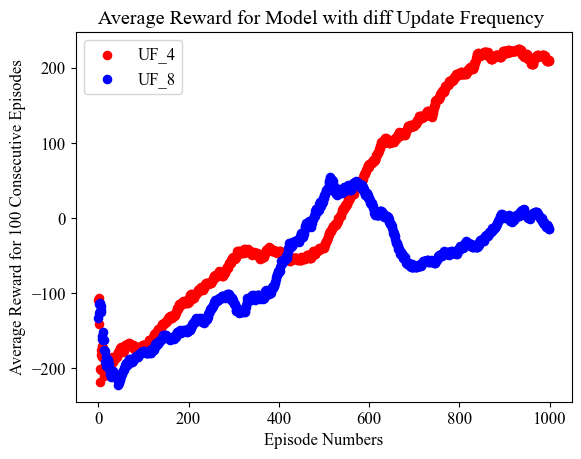

In [67]:
## Scatter Plot
colors ={'UF_4': 'red','UF_8': 'blue'} 

plt.rc('font',family=['Times New Roman', 'SimSun'], size=12)
for i in ['UF_4','UF_8']:
    plt.scatter(np.arange(len(df)), df_100.loc[:,i], s = 35, c = colors[i], label = i)
plt.title('Average Reward for Model with diff Update Frequency ')
plt.ylabel('Average Reward for 100 Consecutive Episodes')
plt.xlabel('Episode Numbers')
plt.legend(loc='upper left')
plt.show()

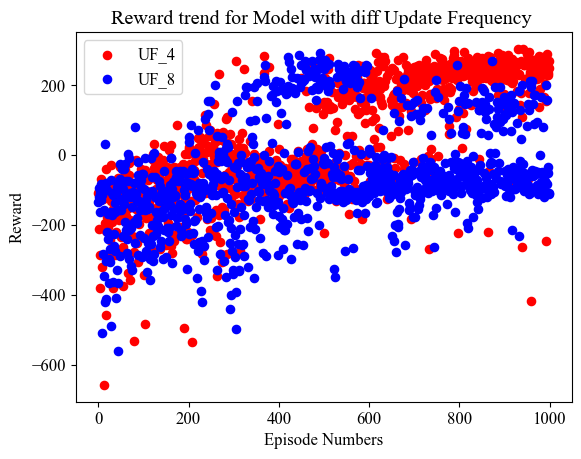

In [68]:
## Scatter Plot
colors ={'UF_4': 'red','UF_8': 'blue'} 

plt.rc('font',family=['Times New Roman', 'SimSun'], size=12)
for i in ['UF_4','UF_8']:
    plt.scatter(np.arange(len(df)), df.loc[:,i], s = 35, c = colors[i], label = i)
plt.title('Reward trend for Model with diff Update Frequency ')
plt.ylabel('Reward')
plt.xlabel('Episode Numbers')
plt.legend(loc='upper left')
plt.show()

##### Batch_size

In [80]:
## HP_batch_size_dict.npy
## HP_TAU_dict.npy
## HP_LR_dict.npy

load_dict=np.load('HP_batch_size_dict.npy',allow_pickle=True).item()
BS_64=load_dict[64][0]
BS_128=load_dict[128][0]
BS_256=load_dict[256][0]

data={'BS_64': BS_64,'BS_128': BS_128,'BS_256': BS_256} 
df = pd.DataFrame(data)
df_100=df.copy()

for i in list(data.keys()):
    scores_on_100_episodes = deque(maxlen=100)
    for j in np.arange(len(df)):
        scores_on_100_episodes.append(df.loc[j,i])      
        df_100.loc[j,i]=np.mean(scores_on_100_episodes)

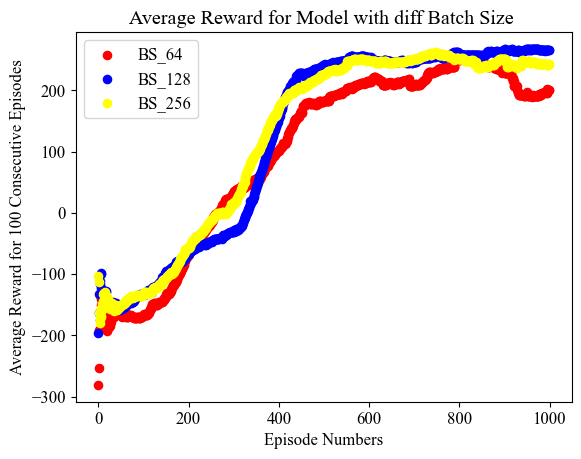

In [70]:
## Scatter Plot
colors ={'BS_64': 'red','BS_128': 'blue','BS_256': 'yellow'} 

plt.rc('font',family=['Times New Roman', 'SimSun'], size=12)
for i in list(data.keys()):
    plt.scatter(np.arange(len(df)), df_100.loc[:,i], s = 35, c = colors[i], label = i)
plt.title('Average Reward for Model with diff Batch Size ')
plt.ylabel('Average Reward for 100 Consecutive Episodes')
plt.xlabel('Episode Numbers')
plt.legend(loc='upper left')
plt.show()

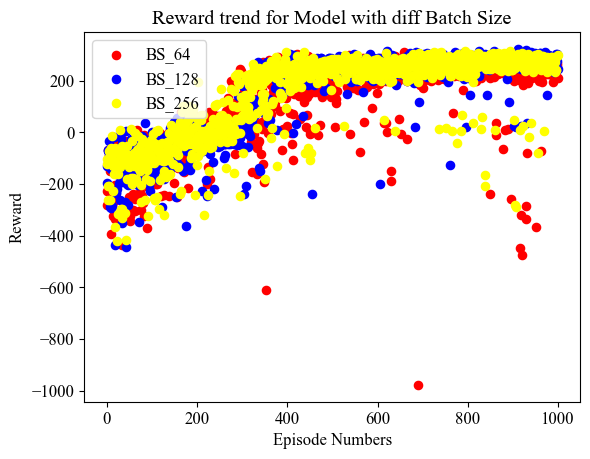

In [81]:
## Scatter Plot
colors ={'BS_64': 'red','BS_128': 'blue','BS_256': 'yellow'} 

plt.rc('font',family=['Times New Roman', 'SimSun'], size=12)
for i in list(data.keys()):
    plt.scatter(np.arange(len(df)), df.loc[:,i], s = 35, c = colors[i], label = i)
plt.title('Reward trend for Model with diff Batch Size')
plt.ylabel('Reward')
plt.xlabel('Episode Numbers')
plt.legend(loc='upper left')
plt.show()

##### TAU

In [82]:
## HP_batch_size_dict.npy
## HP_TAU_dict.npy
## HP_LR_dict.npy

load_dict=np.load('HP_TAU_dict.npy',allow_pickle=True).item()
TAU_0005=load_dict[0.0005][0]
TAU_001=load_dict[0.001][0]
TAU_01=load_dict[0.01][0]
TAU_1=load_dict[0.1][0]

data={'TAU_0005': TAU_0005,'TAU_001': TAU_001,'TAU_01': TAU_01,'TAU_1': TAU_1} 
df = pd.DataFrame(data)
df_100=df.copy()

for i in list(data.keys()):
    scores_on_100_episodes = deque(maxlen=100)
    for j in np.arange(len(df)):
        scores_on_100_episodes.append(df.loc[j,i])      
        df_100.loc[j,i]=np.mean(scores_on_100_episodes)

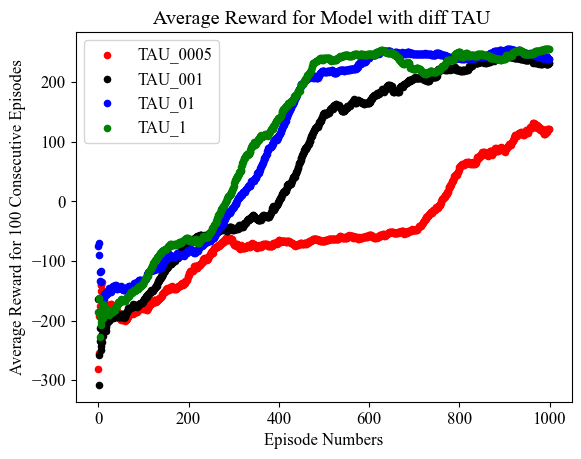

In [79]:
## Scatter Plot
colors ={'TAU_0005': 'red','TAU_001': 'black','TAU_01': 'blue','TAU_1': 'green'} 

plt.rc('font',family=['Times New Roman', 'SimSun'], size=12)
for i in list(data.keys()):
    plt.scatter(np.arange(len(df)), df_100.loc[:,i], s = 20, c = colors[i], label = i)
plt.title('Average Reward for Model with diff TAU ')
plt.ylabel('Average Reward for 100 Consecutive Episodes')
plt.xlabel('Episode Numbers')
plt.legend(loc='upper left')
plt.show()

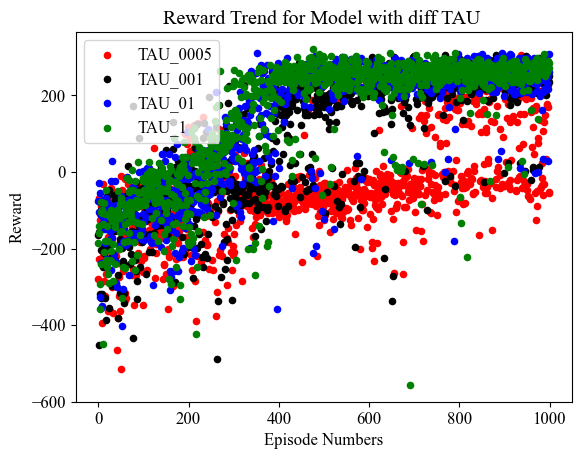

In [83]:
## Scatter Plot
colors ={'TAU_0005': 'red','TAU_001': 'black','TAU_01': 'blue','TAU_1': 'green'} 

plt.rc('font',family=['Times New Roman', 'SimSun'], size=12)
for i in list(data.keys()):
    plt.scatter(np.arange(len(df)), df.loc[:,i], s = 20, c = colors[i], label = i)
plt.title('Reward Trend for Model with diff TAU ')
plt.ylabel('Reward')
plt.xlabel('Episode Numbers')
plt.legend(loc='upper left')
plt.show()

##### LR

In [85]:
## HP_batch_size_dict.npy
## HP_TAU_dict.npy
## HP_LR_dict.npy

load_dict=np.load('HP_LR_dict.npy',allow_pickle=True).item()
LR_0005=load_dict[0.0005][0]
LR_001=load_dict[0.001][0]
LR_01=load_dict[0.01][0]
LR_1=load_dict[0.1][0]

data={'LR_0005': LR_0005,'LR_001': LR_001,'LR_01': LR_01,'LR_1': LR_1} 
df = pd.DataFrame(data)
df_100=df.copy()

for i in list(data.keys()):
    scores_on_100_episodes = deque(maxlen=100)
    for j in np.arange(len(df)):
        scores_on_100_episodes.append(df.loc[j,i])      
        df_100.loc[j,i]=np.mean(scores_on_100_episodes)

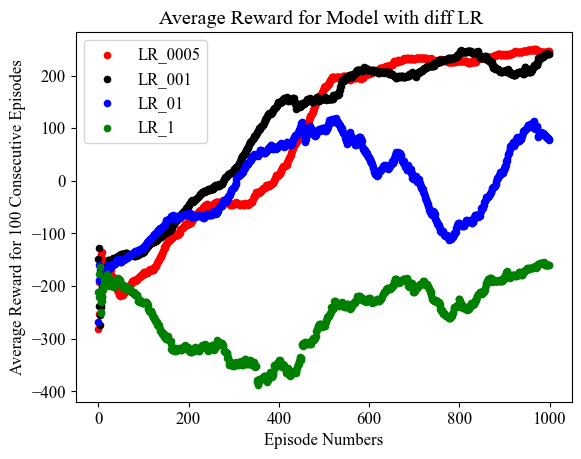

In [86]:
## Scatter Plot
colors ={'LR_0005': 'red','LR_001': 'black','LR_01': 'blue','LR_1': 'green'} 

plt.rc('font',family=['Times New Roman', 'SimSun'], size=12)
for i in list(data.keys()):
    plt.scatter(np.arange(len(df)), df_100.loc[:,i], s = 20, c = colors[i], label = i)
plt.title('Average Reward for Model with diff LR ')
plt.ylabel('Average Reward for 100 Consecutive Episodes')
plt.xlabel('Episode Numbers')
plt.legend(loc='upper left')
plt.show()

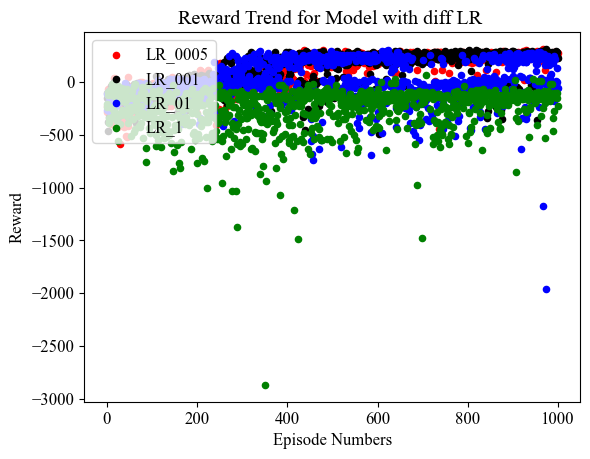

In [87]:
## Scatter Plot
colors ={'LR_0005': 'red','LR_001': 'black','LR_01': 'blue','LR_1': 'green'} 

plt.rc('font',family=['Times New Roman', 'SimSun'], size=12)
for i in list(data.keys()):
    plt.scatter(np.arange(len(df)), df.loc[:,i], s = 20, c = colors[i], label = i)
plt.title('Reward Trend for Model with diff LR ')
plt.ylabel('Reward')
plt.xlabel('Episode Numbers')
plt.legend(loc='upper left')
plt.show()

### Parameter Combination

In [95]:
##i_episode,N_NODES_1,N_NODES_2,batch_size,GAMMA,TAU,LR,UF,eps_start,eps_end,eps_decay_rate)
load_dict=np.load('HP.npy',allow_pickle=True).item()

C_1=load_dict[3][0] ##TAU:0.0005 :LR:0.001
C_2=load_dict[5][0] ##TAU:0.0005 :LR:0.01
C_3=load_dict[7][0] ##TAU:0.0005 :LR:0.1
C_4=load_dict[9][0] ##TAU:0.001 :LR:0..0005
C_5=load_dict[11][0]##TAU:0.001 :LR:0.001
C_6=load_dict[13][0]##TAU:0.001 :LR:0.01
C_7=load_dict[15][0]##TAU:0.001 :LR:0.1

data={'TAU_0005_LR_001': C_1,'TAU_0005_LR_01': C_2,'TAU_0005_LR_1': C_3,'TAU_001_LR_0005': C_4,
      'TAU_001_LR_001': C_5,'TAU_001_LR_01': C_6,'TAU_001_LR_1': C_7
     } 
df = pd.DataFrame(data)
df_100=df.copy()

for i in list(data.keys()):
    scores_on_100_episodes = deque(maxlen=100)
    for j in np.arange(len(df)):
        scores_on_100_episodes.append(df.loc[j,i])      
        df_100.loc[j,i]=np.mean(scores_on_100_episodes)

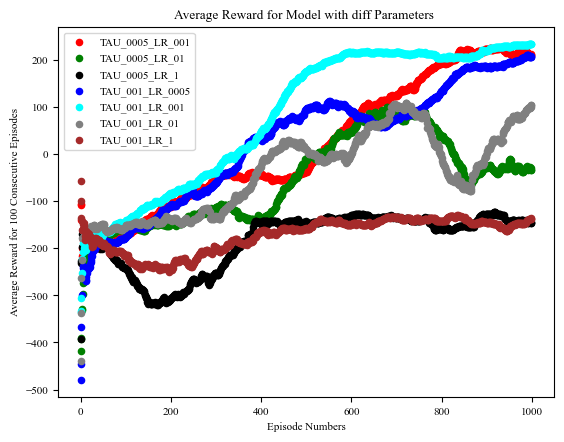

In [97]:
## Scatter Plot
colors ={'TAU_0005_LR_001': 'red','TAU_0005_LR_01': 'green','TAU_0005_LR_1': 'black',
         'TAU_001_LR_0005': 'blue','TAU_001_LR_001': 'Cyan','TAU_001_LR_01': 'gray',
         'TAU_001_LR_1': 'Brown'
     } 
plt.rc('font',family=['Times New Roman', 'SimSun'], size=8)
for i in list(data.keys()):
    plt.scatter(np.arange(len(df)), df_100.loc[:,i], s = 20, c = colors[i], label = i)
plt.title('Average Reward for Model with diff Parameters ')
plt.ylabel('Average Reward for 100 Consecutive Episodes')
plt.xlabel('Episode Numbers')
plt.legend(loc='upper left')
plt.show()